# Detección de Fraude en Transacciones de Tarjetas de Crédito

## Introducción

El fraude con tarjetas de crédito es un problema creciente en el sector financiero. La detección temprana de transacciones fraudulentas es crucial para minimizar pérdidas y proteger a los clientes. En este proyecto, implementaremos un modelo de aprendizaje profundo con redes neuronales para identificar fraudes en transacciones financieras utilizando el conjunto de datos creditcard.csv de Kaggle.

El dataset contiene 284,807 transacciones, de las cuales 492 son fraudulentas (0.172% del total). Debido a esta desproporción de clases, utilizaremos estrategias de balanceo y métricas adecuadas para evaluar el desempeño del modelo.

## Descripción del Dataset

El conjunto de datos contiene transacciones realizadas en septiembre de 2013 por titulares de tarjetas europeos. Por razones de confidencialidad, las características han sido transformadas mediante Análisis de Componentes Principales (PCA), excepto las variables **Tiempo** y **Monto**:

- **V1, V2, ..., V28** → Componentes principales obtenidos con PCA.
- **Tiempo** → Segundos transcurridos desde la primera transacción en el conjunto de datos.
- **Monto** → Valor monetario de la transacción.
- **Clase** → Variable objetivo: 0 (no fraude) y 1 (fraude).
Dada la alta desproporción entre clases, evaluaremos los modelos utilizando AUC-ROC y Precision-Recall Curve, en lugar de métricas tradicionales como la precisión, que pueden ser engañosas en datasets desbalanceados.

## Enfoque y Metodología
Para abordar el problema, seguiremos los siguientes pasos:

### 1. Entendimiento del Problema
- Objetivo: Identificar transacciones fraudulentas con alta precisión y bajo falso positivo.
- Desbalance de clases: Solo 492 casos de fraude en 284,315 transacciones (~0.17% de fraude).
- Riesgo de overfitting: Dado el pequeño número de fraudes, necesitamos técnicas para evitarlo.


## Metodología de Trabajo

#### 1. Exploración y Preparación de Datos
- **Carga y análisis exploratorio:** Importación del dataset y análisis inicial de sus características, distribución y valores faltantes
- **Tratamiento de valores atípicos:** Identificación y manejo de outliers mediante técnicas estadísticas como z-score
- **Preprocesamiento:** Normalización/estandarización de variables numéricas para mejorar el rendimiento de los algoritmos
#### 2. Manejo del Desbalance de Clases
- Implementación de técnicas de submuestreo (NearMiss) y sobremuestreo (SMOTE) para equilibrar la distribución entre transacciones fraudulentas y legítimas
- Evaluación del impacto de estas técnicas en el rendimiento de los modelos
#### 3. Selección de Características
- Análisis de importancia de variables mediante información mutua y otros métodos
- Eliminación de características redundantes o poco relevantes para mejorar la eficiencia
#### 4. Modelado y Evaluación
- **Modelos tradicionales:** Implementación de Random Forest y Regresión Logística
- **Redes neuronales:** Desarrollo de arquitecturas con capas densas y dropout para prevenir sobreajuste
- **Validación cruzada:** Uso de StratifiedKFold para evaluar la robustez de los modelos
- **Métricas de evaluación:** Análisis mediante matrices de confusión, classification report y curvas ROC para evaluar el rendimiento con énfasis en la detección de fraudes
#### 5. Optimización y Ajuste
- Refinamiento de hiperparámetros para maximizar métricas relevantes (precisión, recall, F1-score)
- Comparación sistemática entre diferentes enfoques para seleccionar el modelo final
#### 6. Conclusión:
- Posibles mejoras finales.

## Importancia del Proyecto

Este trabajo es netamente con fines de estudio y para demostrar cómo el deep learning puede abordar problemas reales en el sector financiero. Además, muestra el impacto del desbalance de clases en la clasificación y la necesidad de métricas adecuadas.

El código y análisis serán publicados en GitHub como parte de un portafolio profesional en Ciencia de Datos.

# Carga y Exploración de Datos

### Importar Librerias

In [11]:
# Manejo de datos
import pandas as pd
import numpy as np 
from scipy import stats
from scipy.stats import zscore
import math

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

# Modelos de Machine Learning
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression  

# Evaluación de modelos
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score  

# Redes Neuronales 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Configuración extra
import warnings
warnings.filterwarnings("ignore") 

In [12]:
df = pd.read_csv('creditcard.csv')

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
# Inspección de valores nulos
if df.isnull().sum().any():
    print("Valores nulos encontrados en las siguientes columnas:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("No hay valores nulos en el dataset.")

No hay valores nulos en el dataset.


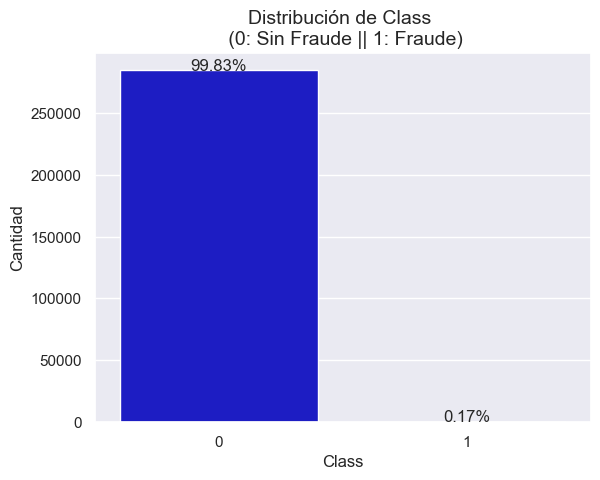

In [15]:
# Calcular las proporciones
class_counts = df['Class'].value_counts()
no_fraudes = class_counts[0] / len(df) * 100
fraudes = class_counts[1] / len(df) * 100

# Crear el gráfico de barras
colors = ["#0101DF", "#DF0101"]
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)

# Añadir los porcentajes encima de las barras
for i, count in enumerate(class_counts):
    plt.text(i, count + 100, f'{round(count / len(df) * 100, 2)}%', ha='center', fontsize=12)

# Configurar título y etiquetas
plt.title('Distribución de Class \n (0: Sin Fraude || 1: Fraude)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

La mayoría de las transacciones no son fraudulentas. Si usamos este dataset como base para nuestros modelos predictivos y análisis, podríamos encontrar muchos errores y nuestros algoritmos probablemente se sobreajustarán, ya que asumirán que la mayoría de las transacciones no son fraudulentas.

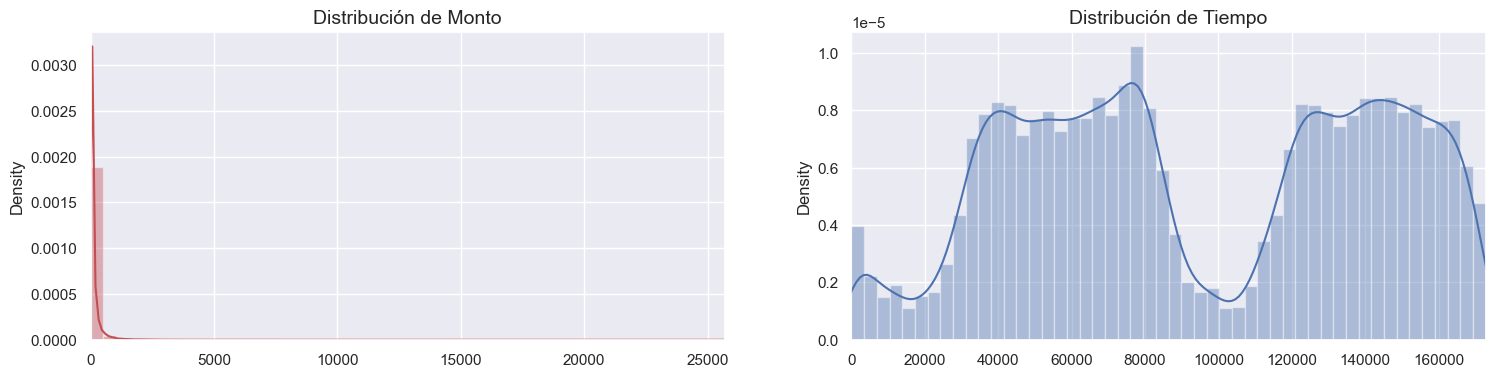

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribución de Monto', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribución de Tiempo', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

#### Notas
- El tiempo y el monto deben escalarse como las demás columnas.
- También necesitamos crear una submuestra del marco de datos para tener la misma cantidad de casos de fraude y no fraude, lo que ayudará a nuestros algoritmos a comprender mejor los patrones que determinan si una transacción es fraudulenta o no.

In [19]:
from sklearn.preprocessing import RobustScaler

# RobustScaler es un método de escalado menos sensible a valores atípicos.
rob_scaler = RobustScaler()

# Escalar 'Amount' y 'Time' y agregar las columnas escaladas al DataFrame
df[['scaled_amount', 'scaled_time']] = rob_scaler.fit_transform(df[['Amount', 'Time']])

# Reubicar 'scaled_amount' y 'scaled_time' al inicio del DataFrame
df = df[['scaled_amount', 'scaled_time'] + [col for col in df.columns if col not in ['scaled_amount', 'scaled_time']]]

# Eliminar Time y Amount
df.drop(['Time','Amount'], axis=1, inplace=True)

# Mostrar el resultado
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### División de datos (DataFrame original)

- Necesitamos deparar el dataframe original para fines de prueba, un porcentaje de training necesita tener balanceado tanto los casos de fraude como no fraude pero en el caso de las pruebas tiene que ser un dataset que esté igual de desbalanceado que el original.

In [21]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Imprimir la distribución de clases en el dataset completo
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Separar las variables predictoras (X) de la variable objetivo (y)
X = df.drop('Class', axis=1)  # Variables independientes (sin la columna 'Class')
y = df['Class']  # Variable dependiente (la columna 'Class' que indica fraude/no fraude)

# Definir el objeto StratifiedKFold para realizar la validación cruzada estratificada
# La opción n_splits=5 divide el dataset en 5 subconjuntos. 
# La validación estratificada asegura que las proporciones de las clases se mantengan en cada subconjunto.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Realizar la división estratificada del dataset en 5 partes
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    
    # Dividir los datos en subconjuntos de entrenamiento y prueba usando los índices generados
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]  # Dividir X en X_train y X_test
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]  # Dividir y en y_train y y_test

# Convertir los DataFrames a arrays de NumPy
# Esto es común en ML para evitar posibles problemas de compatibilidad entre diferentes bibliotecas y modelos
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Verificar la distribución de las clases en los conjuntos de entrenamiento y prueba
# Esto es importante para asegurarse de que la división estratificada mantuvo la proporción de clases en cada subconjunto
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)  # Contar clases en el entrenamiento
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)    # Contar clases en la prueba

# Imprimir una línea separadora para organizar el output
print('-' * 100)

# Imprimir las distribuciones de las clases en el conjunto de entrenamiento y prueba
print('Label Distributions: \n')
# Mostrar la proporción de cada clase en los subconjuntos de entrenamiento y prueba
print(train_counts_label / len(original_ytrain))  # Proporción de clases en el entrenamiento
print(test_counts_label / len(original_ytest))   # Proporción de clases en la prueba

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [22]:
# Dado que las clases están altamente desbalanceadas (hay muchas más muestras de "No Fraude" que de "Fraude"),
# queremos equilibrar las clases para mejorar la distribución y la eficacia del modelo. 
# Esto es importante para evitar que el modelo favorezca excesivamente la clase mayoritaria.

# Barajar el DataFrame para mezclar aleatoriamente las filas antes de crear las submuestras
df = df.sample(frac=1)  # 'frac=1' significa que barajamos todo el conjunto de datos

# Filtrar las filas donde la clase es 'Fraude' (1)
fraud_df = df.loc[df['Class'] == 1]  # Subconjunto solo con fraudes (clase 1)

# Filtrar las filas donde la clase es 'No Fraude' (0), pero limitando a las primeras 492 filas
# Esto se hace porque se quiere equilibrar las clases con un total de 492 muestras para ambas clases
non_fraud_df = df.loc[df['Class'] == 0][:492]  # Subconjunto solo con no fraudes (clase 0)

# Concatenar ambos subconjuntos (fraude y no fraude) para crear un DataFrame equilibrado
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Barajar las filas del nuevo DataFrame equilibrado (ahora tenemos la misma cantidad de fraudes y no fraudes)
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# Mostrar las primeras filas del DataFrame equilibrado
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
148170,-0.195766,0.056568,-3.796102,3.312477,-3.615703,-3.096374,3.133422,2.579526,1.494762,0.280859,...,2.071396,-0.530725,0.648287,-0.162159,0.695788,0.382327,-0.042214,0.243390,-0.600601,0
83297,4.152868,-0.292708,-8.257111,-4.814461,-5.365307,1.204230,-3.347420,-1.331601,-1.967893,1.295438,...,-1.233987,0.436390,-0.077553,-3.091624,-0.390201,-0.288689,-0.340004,0.039819,-1.007900,1
281080,0.249144,1.001375,-0.809194,0.887939,0.325269,0.185913,-0.440904,-0.509049,-0.142350,0.214691,...,0.128873,0.028454,0.503251,0.048380,-0.102184,-1.037020,-0.468858,0.063011,0.009546,0
151462,-0.284636,0.127668,-16.308650,11.614801,-19.739386,10.463866,-12.599146,-1.202393,-23.380508,-5.781133,...,2.106034,-4.884983,1.140910,1.392953,0.348997,-2.167510,-0.798754,-2.942775,-0.462680,1
204064,4.513379,0.592147,0.232512,0.938944,-4.647780,3.079844,-1.902655,-1.041408,-1.020407,0.547069,...,1.141615,0.911373,1.042929,0.999394,0.901260,-0.452093,0.192959,0.180859,-0.029315,1


##  Equitativamente Distribuido y Correlacionado:
Ahora que tenemos nuestro dataframe correctamente balanceado, podemos continuar con el análisis y preprocesamiento

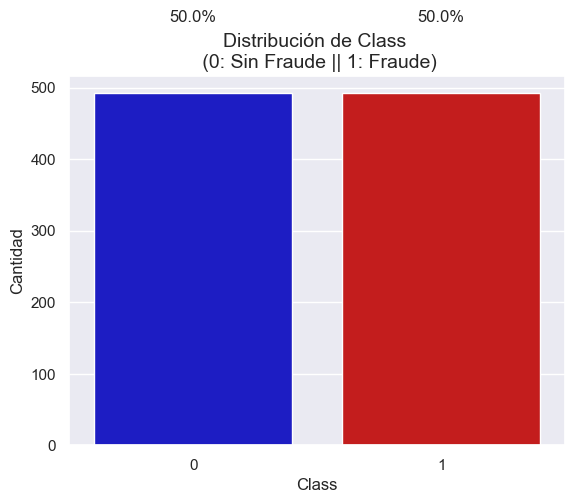

In [24]:
# Calcular las nuevas proporciones
class_counts = new_df['Class'].value_counts()
no_fraudes = class_counts[0] / len(new_df) * 100
fraudes = class_counts[1] / len(new_df) * 100

# Crear el gráfico de barras
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)

# Añadir los porcentajes encima de las barras
for i, count in enumerate(class_counts):
    plt.text(i, count + 100, f'{round(count / len(new_df) * 100, 2)}%', ha='center', fontsize=12)

# Configurar título y etiquetas
plt.title('Distribución de Class \n (0: Sin Fraude || 1: Fraude)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

### Matríz de Correlación
Queremos saber si existen características que influyen significativamente en si una transacción específica es un fraude.

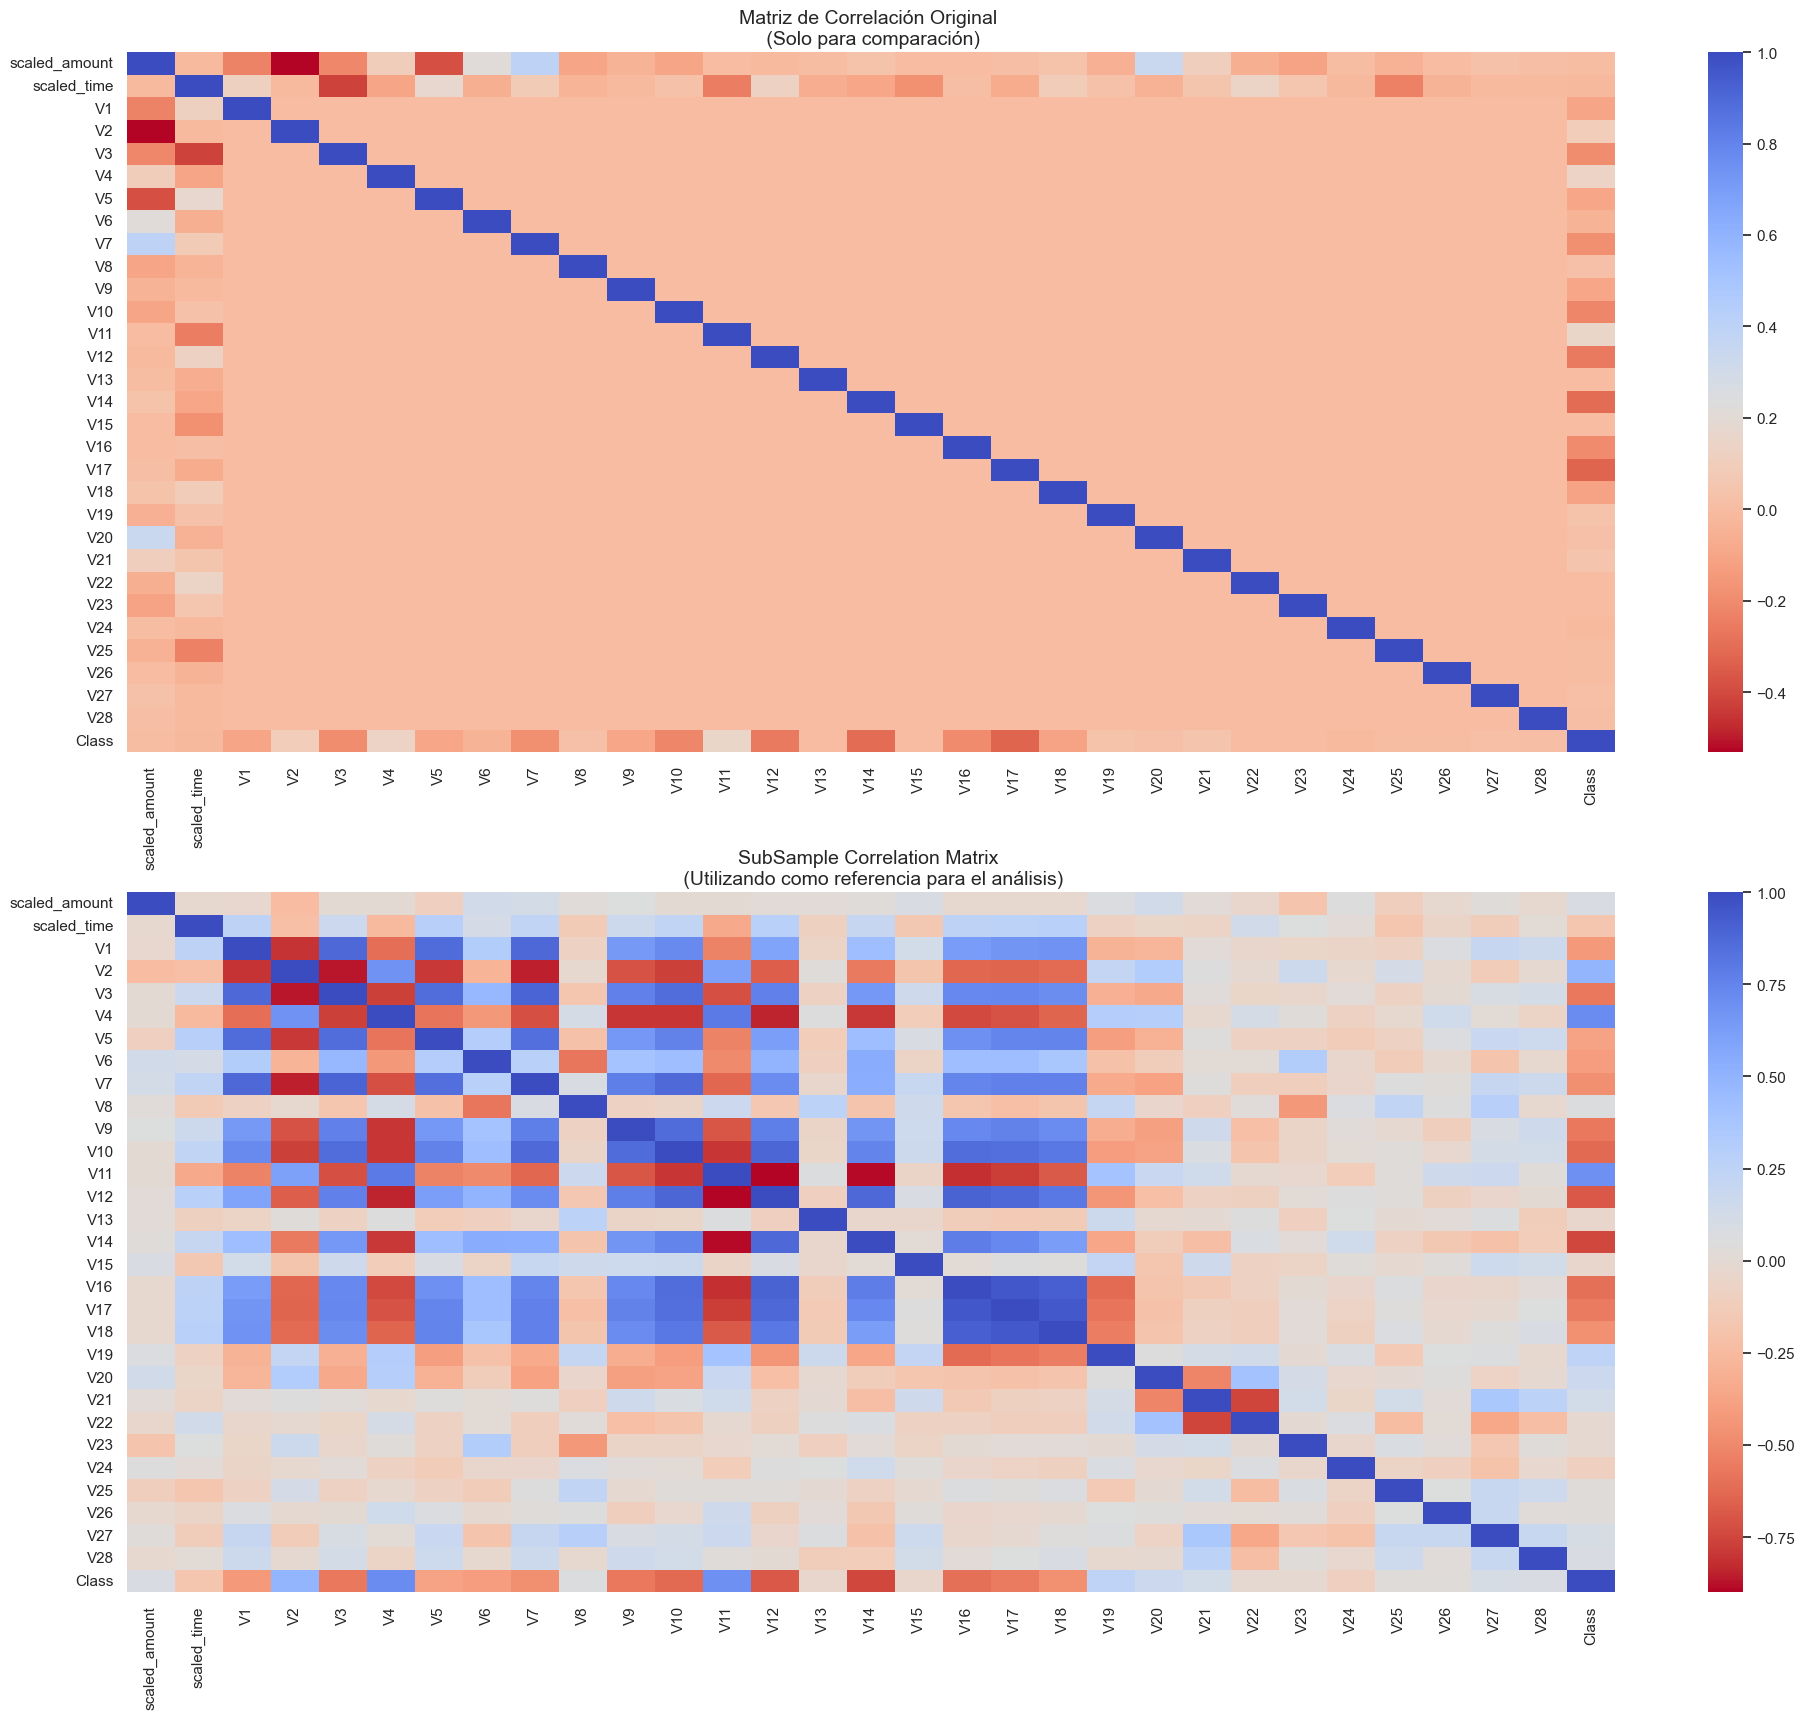

In [26]:
# Crear una figura con dos subgráficas para mostrar las matrices de correlación
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))  

# Calcular la matriz de correlación para el DataFrame original
corr = df.corr()  

# Dibujar el heatmap para la matriz de correlación del DataFrame original
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20}, ax=ax1)
ax1.set_title("Matriz de Correlación Original \n (Solo para comparación)", fontsize=14)

# Calcular la matriz de correlación para el subconjunto equilibrado
sub_sample_corr = new_df.corr()  

# Dibujar el heatmap para la matriz de correlación del subconjunto equilibrado
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size': 20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (Utilizando como referencia para el análisis)', fontsize=14)

# Mostrar ambos gráficos
plt.show()

#### Notas:
- Correlaciones negativas: V14, V12, V10, V16 y V3 presentan una correlación negativa clara.
    - Cuanto más bajos sean estos valores, mayor será la probabilidad de que el resultado final sea una transacción fraudulenta.
- Correlaciones positivas: V11, V4, V2 y V19 presentan una correlación positiva clara.
    - Cuanto más altos sean estos valores, mayor será la probabilidad de que el resultado final sea una transacción fraudulenta.

### ANÁLISIS OUTLIERS CORRELACIONES NEGATIVAS (Buscando reducir outliers)

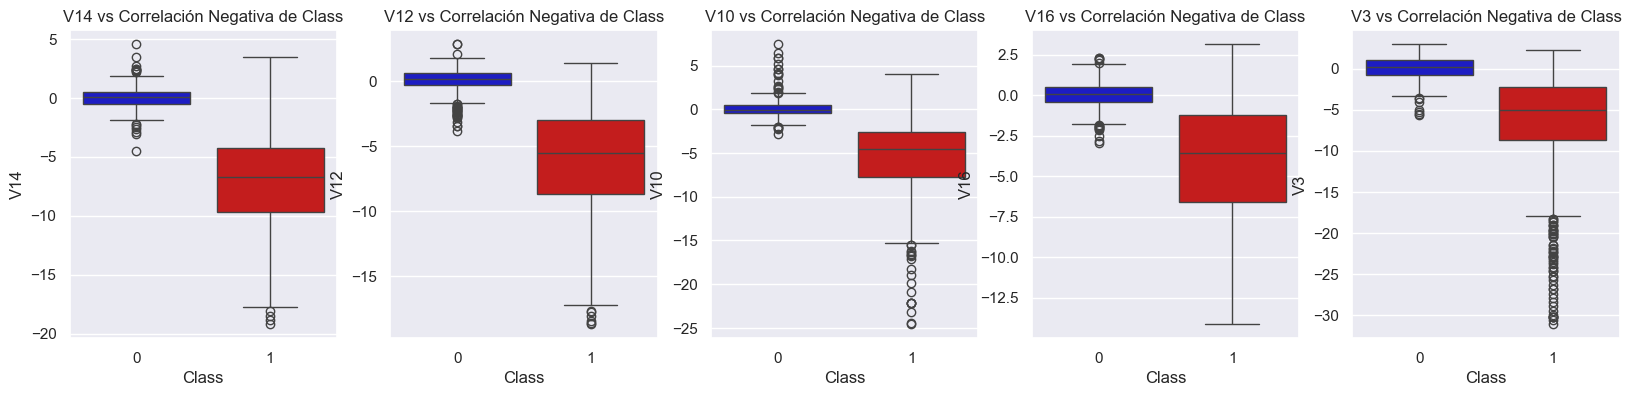

In [29]:
f, axes = plt.subplots(ncols=5, figsize=(20,4))

# Correlaciones negativas cuanto más bajos sean estos valores, mayor será la probabilidad de fraude
sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V14 vs Correlación Negativa de Class')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Correlación Negativa de Class')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V10 vs Correlación Negativa de Class')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Correlación Negativa de Class')

sns.boxplot(x="Class", y="V3", data=new_df, palette=colors, ax=axes[4])
axes[4].set_title('V3 vs Correlación Negativa de Class')


plt.show()

La mayor cantidad de outliers para transacciones fraudulentas se pueden visualizar en las variables V14, V12, V10, V3, vamos a visualizar sus distribuciones con un ajuste de distribución normal (óptimo para la implementación de modelos de ML)

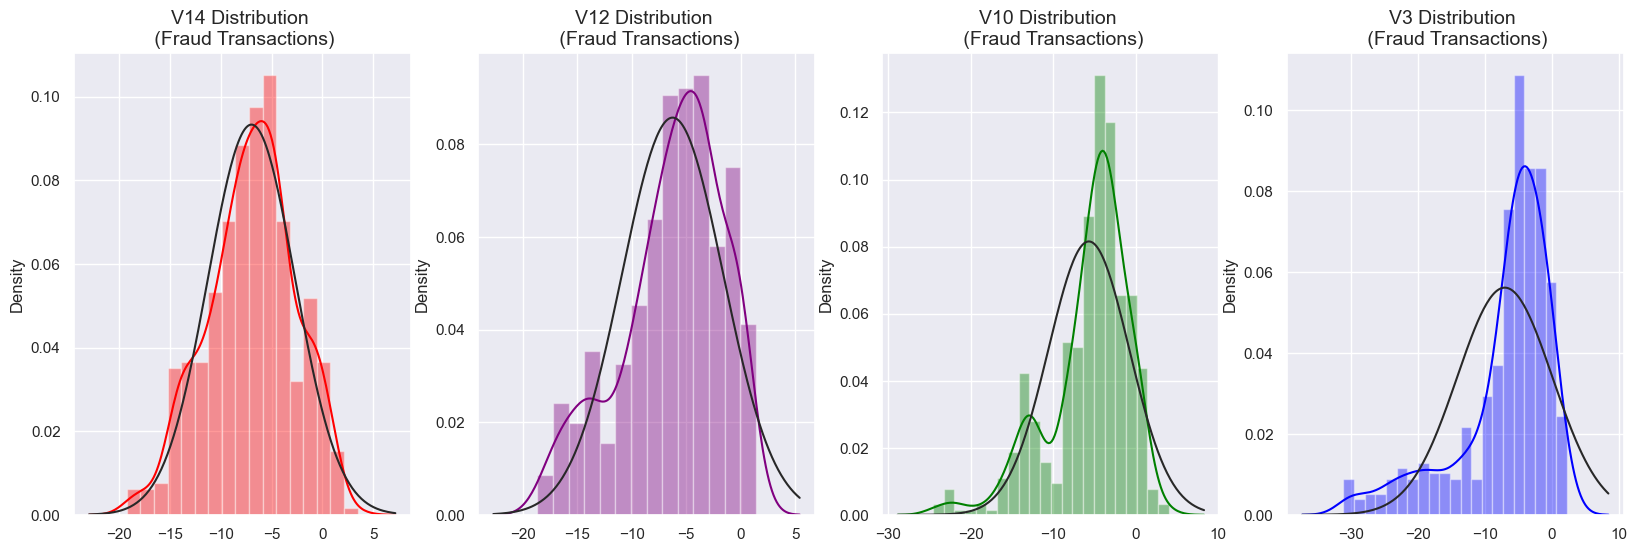

In [31]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FF0000')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#800080')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#008000')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v3_fraud_dist = new_df['V3'].loc[new_df['Class'] == 1].values
sns.distplot(v3_fraud_dist,ax=ax4, fit=norm, color='#0000FF')
ax4.set_title('V3 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

- V14 es la única característica con distribución gaussiana, a diferencia de V12, V10 y V3.
- En particular ninguna de estas distribuciones es realmente el ideal que buscamos para un modelado ML, por lo que a continuación vamos a eliminar los outliers en fraudes en el rango intercuartílico (IQR)

In [33]:
## REMOVIENDO OUTLIERS EN FRAUDES EN EL RANGO INTERCUARTÍLICO (IQR)
## -----> V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Límite de corte: {}'.format(v14_cut_off))
print('V14 límite inferior: {}'.format(v14_lower))
print('V14 límite superior: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Valores atípicos en V14: {}'.format(outliers))
print('Cantidad de valores atípicos en V14 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)




## -----> V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('IQR: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Límite de corte: {}'.format(v12_cut_off))
print('V12 límite inferior: {}'.format(v12_lower))
print('V12 límite superior: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Valores atípicos en V12: {}'.format(outliers))
print('Cantidad de valores atípicos en V12 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Número de instancias después de eliminar valores atípicos: {}'.format(len(new_df)))
print('----' * 44)



## -----> V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('IQR: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Límite de corte: {}'.format(v10_cut_off))
print('V10 límite inferior: {}'.format(v10_lower))
print('V10 límite superior: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Valores atípicos en V10: {}'.format(outliers))
print('Cantidad de valores atípicos en V10 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Número de instancias después de eliminar valores atípicos: {}'.format(len(new_df)))
print('----' * 44)



## -----> V3
v3_fraud = new_df['V3'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v3_fraud, 25), np.percentile(v3_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v3_iqr = q75 - q25
print('IQR: {}'.format(v3_iqr))

v3_cut_off = v3_iqr * 1.5
v3_lower, v3_upper = q25 - v3_cut_off, q75 + v3_cut_off
print('Límite de corte: {}'.format(v3_cut_off))
print('V3 límite inferior: {}'.format(v3_lower))
print('V3 límite superior: {}'.format(v3_upper))

outliers = [x for x in v3_fraud if x < v3_lower or x > v3_upper]
print('Valores atípicos en V3: {}'.format(outliers))
print('Cantidad de valores atípicos en V3 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V3'] > v3_upper) | (new_df['V3'] < v3_lower)].index)
print('Número de instancias después de eliminar valores atípicos: {}'.format(len(new_df)))
print('----' * 44)


Cuartil 25: -9.692722964972386 | Cuartil 75: -4.282820849486865
IQR: 5.409902115485521
Límite de corte: 8.114853173228282
V14 límite inferior: -17.807576138200666
V14 límite superior: 3.8320323237414167
Valores atípicos en V14: [-19.2143254902614, -18.4937733551053, -18.0499976898594, -18.8220867423816]
Cantidad de valores atípicos en V14 para casos de fraude: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cuartil 25: -8.67303320439115 | Cuartil 75: -2.893030568676315
IQR: 5.780002635714835
Límite de corte: 8.670003953572252
V12 límite inferior: -17.3430371579634
V12 límite superior: 5.776973384895937
Valores atípicos en V12: [-18.5536970096458, -18.6837146333443, -18.4311310279993, -18.0475965708216]
Cantidad de valores atípicos en V12 para casos de fraude: 4
Número de instancias después de eliminar valores atípicos: 975
----------------------------------

### Visualización de Boxplots con outliers removidos

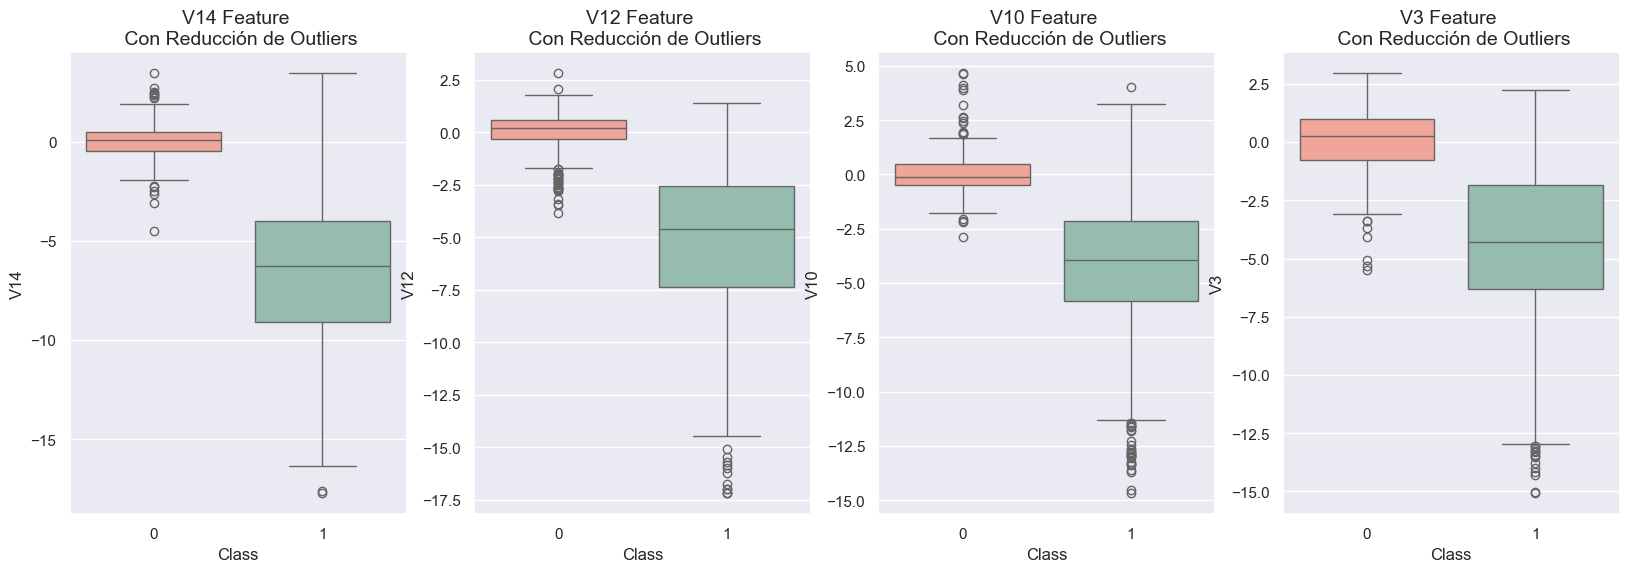

In [35]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#FF9A8B', '#8EC3B0']

# Boxplots con los outliers removidos
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Con Reducción de Outliers", fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Con Reducción de Outliers", fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Con Reducción de Outliers", fontsize=14)

# Feature V3
sns.boxplot(x="Class", y="V3", data=new_df, ax=ax4, palette=colors)
ax4.set_title("V3 Feature \n Con Reducción de Outliers", fontsize=14)

plt.show()

### ANÁLISIS OUTLIERS CORRELACIONES POSITIVAS (Buscando reducir outliers)

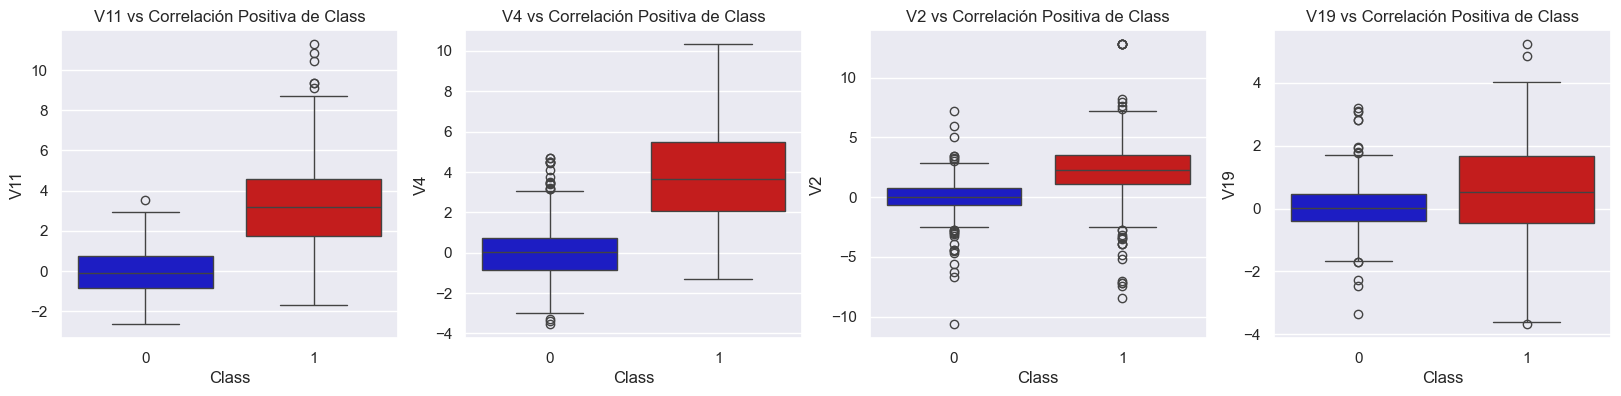

In [37]:
colors = ["#0101DF", "#DF0101"]
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Correlaciones positivas cuanto más altos sean estos valores, mayor será la probabilidad de fraude
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Correlación Positiva de Class')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Correlación Positiva de Class')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Correlación Positiva de Class')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Correlación Positiva de Class')

plt.show()

La mayor cantidad de outliers para transacciones fraudulentas se pueden visualizar en las variables V11, V2 y V19 vamos a visualizar sus distribuciones con un ajuste de distribución normal (óptimo para la implementación de modelos de ML)

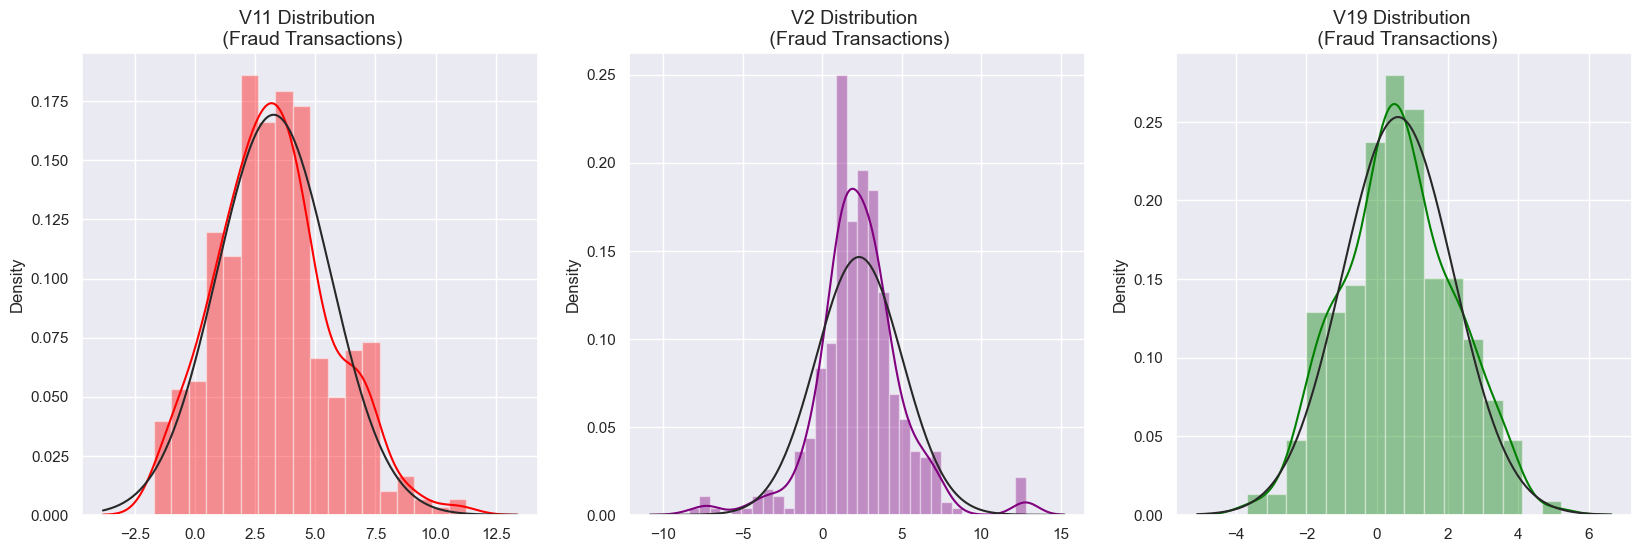

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax1, fit=norm, color='#FF0000')
ax1.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(v2_fraud_dist,ax=ax2, fit=norm, color='#800080')
ax2.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax3, fit=norm, color='#008000')
ax3.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

- V19 es la única característica con distribución más cercana a la gaussiana
- A continuación vamos a eliminar los outliers en fraudes en el límite superior del rango intercuartílico (IQR) de V11, V2 y V9

In [41]:
## -----> V2
v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v2_iqr = q75 - q25
print('IQR: {}'.format(v2_iqr))

v2_cut_off = v2_iqr * 1.5
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Límite de corte: {}'.format(v2_cut_off))
print('V2 límite inferior: {}'.format(v2_lower))
print('V2 límite superior: {}'.format(v2_upper))

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Valores atípicos en V2: {}'.format(outliers))
print('Cantidad de valores atípicos en V2 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V2'] > v2_upper) | (new_df['V2'] < v2_lower)].index)
print('Número de instancias después de eliminar valores atípicos: {}'.format(len(new_df)))
print('----' * 44)

## -----> V11
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('IQR: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 1.5
v11_upper = q75 + v11_cut_off
print('Límite de corte: {}'.format(v11_cut_off))
print('V11 límite superior: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x > v11_upper]
print('Valores atípicos en V11: {}'.format(outliers))
print('Cantidad de valores atípicos en V11 para casos de fraude: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[new_df['V11'] > v11_upper].index)
print('Número de instancias después de eliminar valores atípicos: {}'.format(len(new_df)))
print('----' * 44)


Cuartil 25: 1.07309853428207 | Cuartil 75: 3.56342789803106
IQR: 2.49032936374899
Límite de corte: 3.735494045623485
V2 límite inferior: -2.662395511341415
V2 límite superior: 7.298921943654545
Valores atípicos en V2: [-4.81446073955621, -3.93591892431521, 12.785970638298, 7.36554648639464, -3.15730712090228, -5.19836019923329, -3.4204679837707, 7.91463349246877, -7.19697963053735, -7.15904171709445, 12.785970638298, 7.63974510878724, 12.785970638298, 12.785970638298, 12.785970638298, 12.785970638298, -3.95232008590575, -3.93073139597263, -2.72266032465254, -3.34843873033788, -2.71426804459821, -7.44901515872674, -3.48813018118561, 8.20479650456012, -6.97642000754641, -8.40215367768915]
Cantidad de valores atípicos en V2 para casos de fraude: 26
Número de instancias después de eliminar valores atípicos: 861
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cuar

### Visualización de Boxplots con outliers removidos

Text(0.5, 1.0, 'V2 Feature \n Con Reducción de Outliers')

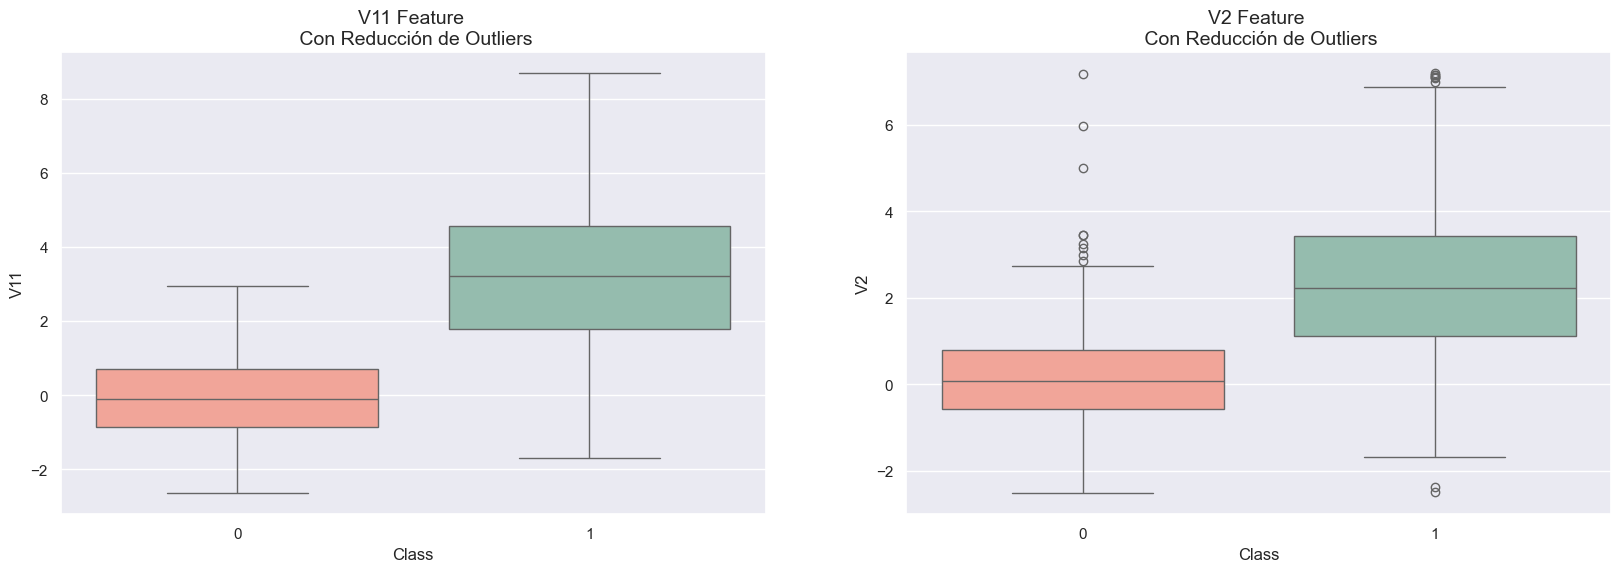

In [43]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

colors = ['#FF9A8B', '#8EC3B0']

# Boxplots con los outliers removidos

# Feature V11
sns.boxplot(x="Class", y="V11", data=new_df, ax=ax1, palette=colors)
ax1.set_title("V11 Feature \n Con Reducción de Outliers", fontsize=14)

# Feature V2
sns.boxplot(x="Class", y="V2", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V2 Feature \n Con Reducción de Outliers", fontsize=14)

### Reducción de Dimensionalidad y Agrupamiento

A continuación vamos a probar tres técnicas de reducción de dimensionalidad (t-SNE, PCA y TruncatedSVD) Para medir y mostrar el tiempo que tomó cada una de estas técnicas para completar la reducción de dimensionalidad.

- **t-SNE:** Técnica no lineal para reducción de dimensiones y visualización.
- **PCA:** Técnica lineal para reducción de dimensiones, enfocada en mantener la varianza.
- **Truncated SVD:** Técnica que también realiza una descomposición similar a PCA, pero de manera más eficiente en términos computacionales, especialmente con matrices dispersas.

In [46]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.9 s
PCA took 0.0025 s
Truncated SVD took 0.83 s


- Los resultados indican que t-SNE es significativamente más lento y computacionalmente intensivo que las técnicas lineales como PCA y Truncated SVD. 
- A continuación vamos a ver una representación visual que capture qué tan bien logran separar las clases cada una de estas técnicas

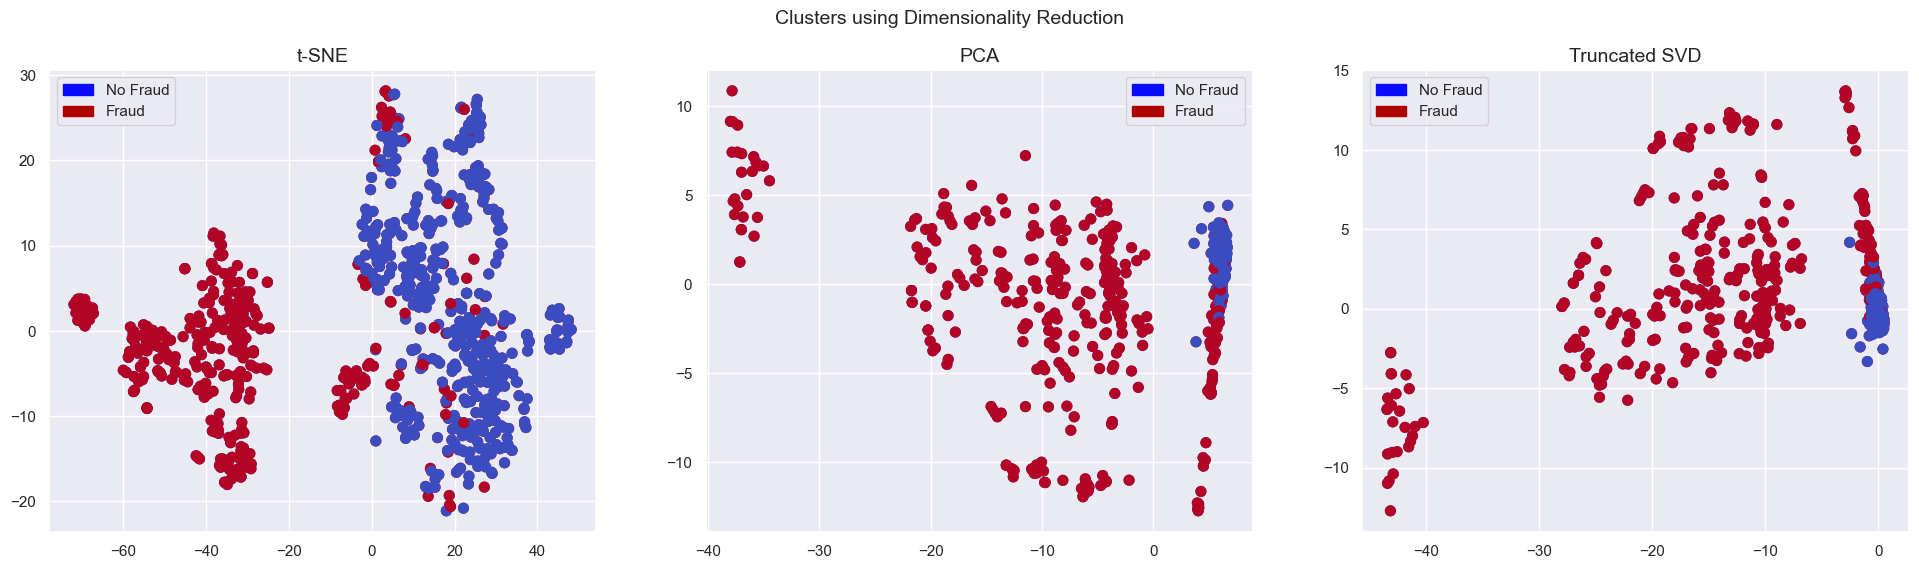

In [48]:
import matplotlib.patches as mpatches
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Evidentemente ninguna de las 3 logra una separación de clases completa, todas muestras cierta superposición de clases, lo cual quiere decir que las clases no son fácilmente separables o que la técnica no ha logrado capturar las diferencias clave entre las clases. Finalmente el tamaño y forma de los grupos igualmente se ven algo dispersos de lo que nos gustaría y en comparación a como se ven para PCA y Truncated SVD

### Clasificadores (Submuestreo):
En esta sección, entrenaremos cuatro tipos de clasificadores y decidiremos cuál será más eficaz para detectar transacciones fraudulentas. Antes de esto, dividiremos nuestros datos en conjuntos de entrenamiento y prueba, y separaremos las características de las etiquetas.

## Resumen:

El clasificador de regresión logística es más preciso que los otros tres en la mayoría de los casos. (Analizaremos la regresión logística con más detalle).

- GridSearchCV se utiliza para determinar los parámetros que ofrecen la mejor puntuación predictiva para los clasificadores.
- La regresión logística tiene la mejor puntuación de la característica operativa receptora (ROC), lo que significa que separa con bastante precisión las transacciones fraudulentas de las no fraudulentas.


## Curvas de aprendizaje:

- Cuanto mayor sea la diferencia entre la puntuación de entrenamiento y la de validación cruzada, mayor será la probabilidad de que el modelo presente un sobreajuste (varianza alta).
- Si la puntuación es baja tanto en el conjunto de entrenamiento como en el de validación cruzada, esto indica que nuestro modelo presenta un subajuste (sesgo alto).
- El clasificador de regresión logística muestra la mejor puntuación tanto en el conjunto de entrenamiento como en el de validación cruzada.

In [52]:
# Submuestreo antes de la validación cruzada (propenso al sobreajuste)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [53]:
# Nuestros datos ya están escalados, debemos dividir nuestros conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Esto se utiliza explícitamente para submuestreo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Convierte los valores en una matriz para alimentar los algoritmos de clasificación.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [55]:
# Implementemos clasificadores simples
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [56]:
# Nuestras puntuaciones obtienen puntuaciones realmente altas para todos los casos!
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Tiene una puntuación de entrenamiento de", round(training_score.mean(), 2) * 100, "% de exactitud")

Classifiers:  LogisticRegression Tiene una puntuación de entrenamiento de 94.0 % de exactitud
Classifiers:  KNeighborsClassifier Tiene una puntuación de entrenamiento de 94.0 % de exactitud
Classifiers:  SVC Tiene una puntuación de entrenamiento de 94.0 % de exactitud
Classifiers:  DecisionTreeClassifier Tiene una puntuación de entrenamiento de 91.0 % de exactitud


In [57]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [58]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.03%
Knears Neighbors Cross Validation Score 93.86%
Support Vector Classifier Cross Validation Score 94.74%
DecisionTree Classifier Cross Validation Score 92.54%


In [59]:
from collections import Counter
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56956  56957  56958 ... 284804 284805 284806] Test: [    0     1     2 ... 58465 60053 60366]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56956  56957  56958 ... 116853 117227 117251]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113919 113920 113921 ... 170885 170886 170887]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170309 170812 170861 ... 227843 227844 227845]
Train: [     0      1      2 ... 227843 227844 227845] Test: [227846 227847 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


- Ahora vamos a generar las curvas de aprendizaje de los cuatro modelos diferentes de clasificación: Regresión Logística, K-Nearest Neighbors (KNN), Máquinas de Vectores de Soporte (SVM) y Árbol de Decisión (Decision Tree). 
- La curva de aprendizaje es una herramienta útil para evaluar el rendimiento de un modelo de aprendizaje automático en función del tamaño del conjunto de entrenamiento. Esto permite observar cómo cambian las métricas de rendimiento a medida que se utiliza un mayor número de datos para entrenar el modelo.

In [61]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

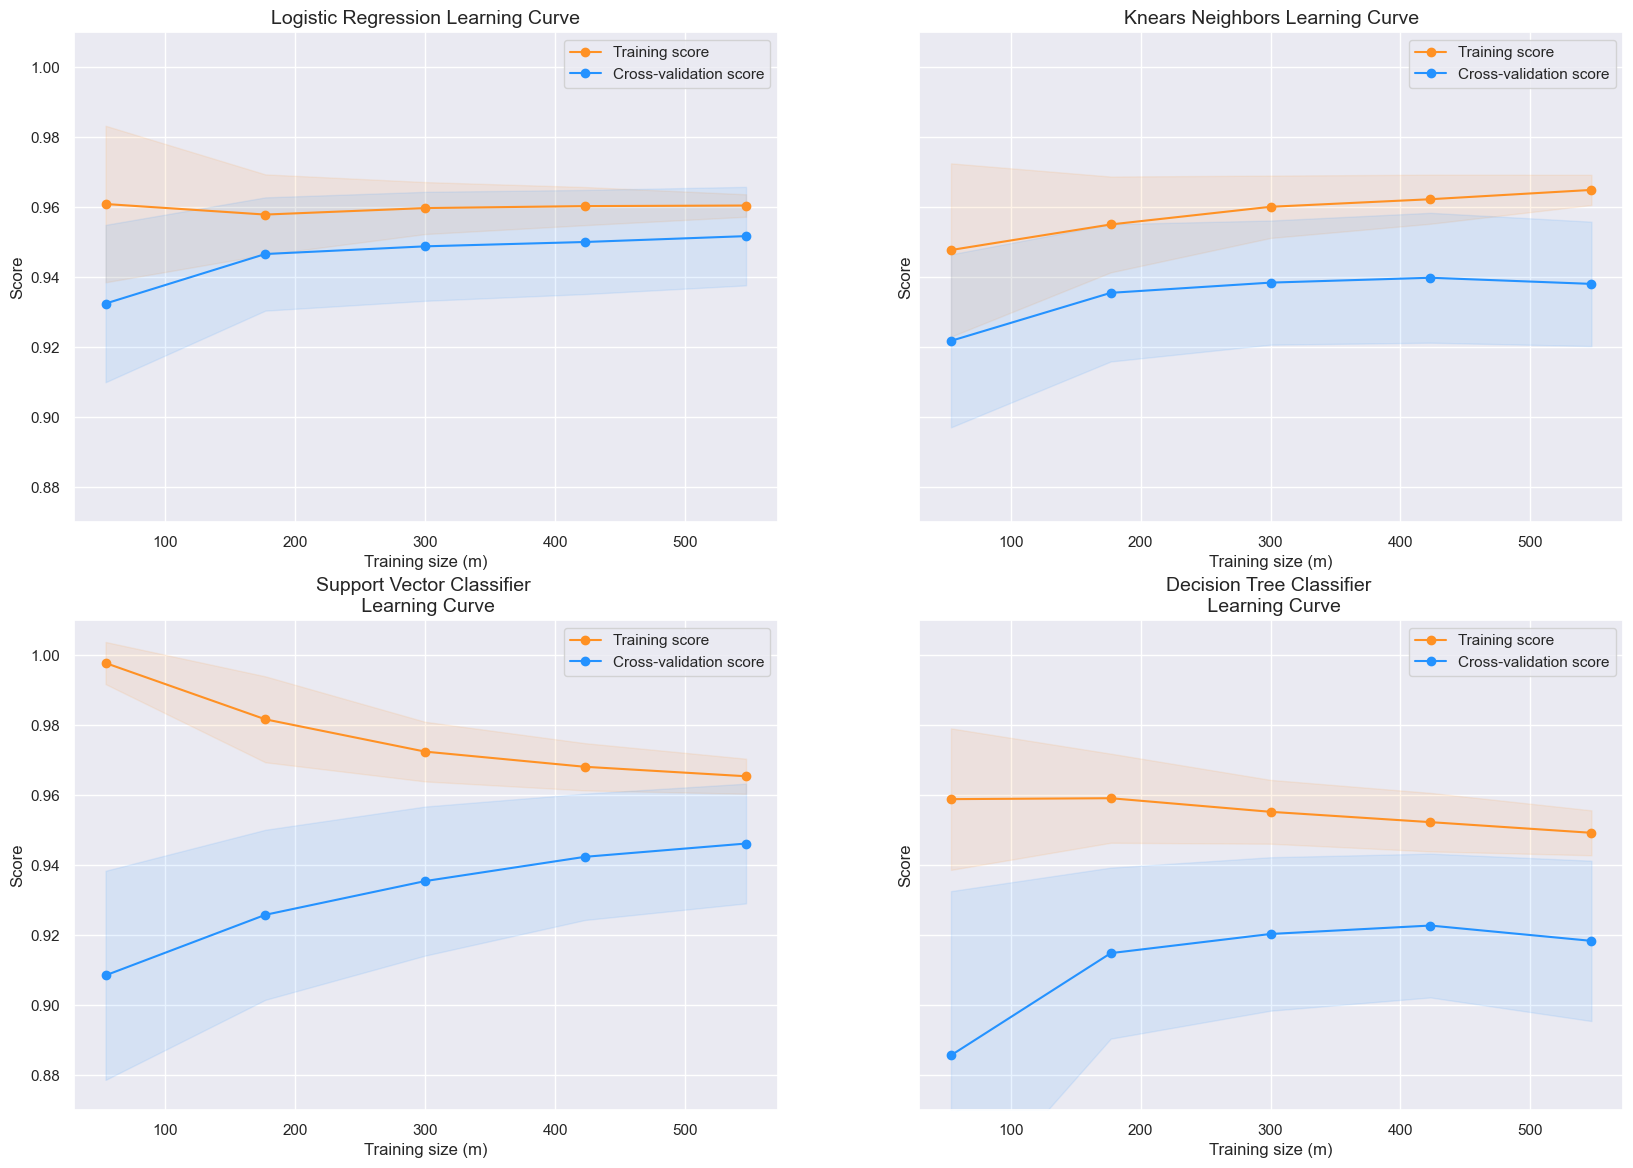

In [62]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

### Resumen:
- La Regresión Logística y KNN parecen ofrecer el mejor equilibrio entre rendimiento y generalización.
- El SVM muestra una buena mejora con más datos, mientras que el Árbol de Decisión parece estar consistentemente sobreajustado.
- Basado en el análisis de las curvas de aprendizaje:
    - Regresión Logística: Buen balance, sin sobreajuste, rendimiento estable
    - KNN: Rendimiento sólido, ligera tendencia al sobreajuste
    - SVM: Inicialmente sobreajustado pero mejora significativamente con más datos
    - Árbol de Decisión: Muestra sobreajuste persistente que no se corrige con más datos
- Para mejorar estos modelos, vamos a realizar una validación cruzada con la métrica ROC AUC para todos los modelos

In [64]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [65]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9788356590218292
KNears Neighbors:  0.9344604863221884
Support Vector Classifier:  0.9736373998342083
Decision Tree Classifier:  0.9213180436584693


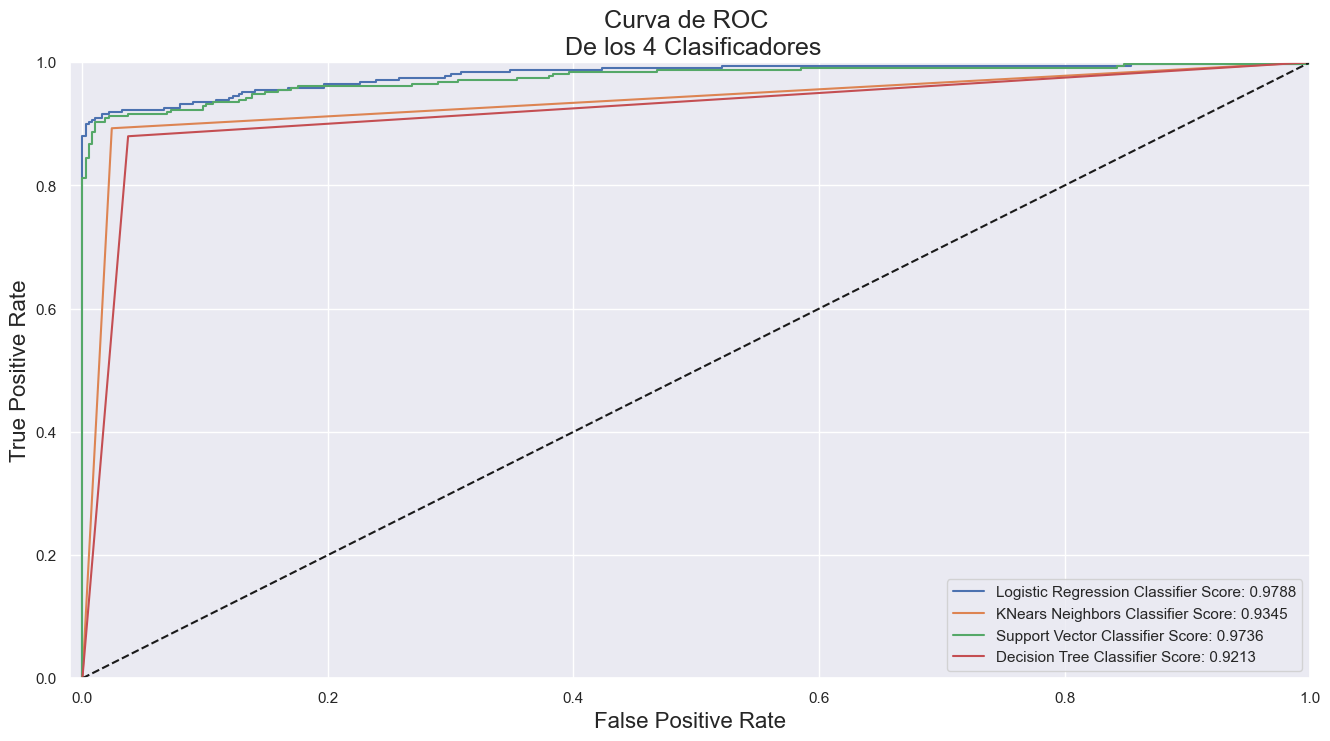

In [66]:
# Comparar las curvas ROC de 4 clasificadores diferentes y graficarlas en un solo gráfico

# Cálculo de las curvas ROC para cada clasificador
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)  # Regresión Logística
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)  # K-Nearest Neighbors
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)  # Support Vector Classifier
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)  # Árbol de Decisión

# Función para graficar las curvas ROC de los clasificadores
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))  # Tamaño de la figura
    plt.title('Curva de ROC \n De los 4 Clasificadores', fontsize=18)  # Título del gráfico

    # Graficar cada clasificador con su ROC AUC score
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))

    # Línea de referencia para rendimiento aleatorio
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    
    plt.axis([-0.01, 1, 0, 1])  # Ajuste de los límites de los ejes
    plt.xlabel('False Positive Rate', fontsize=16)  # Etiqueta del eje X
    plt.ylabel('True Positive Rate', fontsize=16)  # Etiqueta del eje Y

    # Mostrar la leyenda con la descripción de cada curva
    plt.legend()

# Llamada a la función para graficar
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)

# Mostrar la gráfica
plt.show()


## Análisis más profundo de la regresión logística:
En esta sección, profundizaremos en el clasificador de regresión logística.

### Términos:
- **Verdaderos positivos:** Transacciones fraudulentas correctamente clasificadas
- **Falsos positivos:** Transacciones fraudulentas incorrectamente clasificadas
- **Verdadero negativo:** Transacciones no fraudulentas correctamente clasificadas
- **Falso negativo:** Transacciones no fraudulentas incorrectamente clasificadas
- **Precisión:** Verdaderos positivos/(Verdaderos positivos + Falsos positivos)
- **Recordatorio:** Verdaderos positivos/(Verdaderos positivos + Falsos negativos)

La precisión, como su nombre lo indica, indica la precisión (la seguridad) de nuestro modelo para detectar transacciones fraudulentas, mientras que el recordatorio se refiere a la cantidad de casos de fraude que nuestro modelo puede detectar.

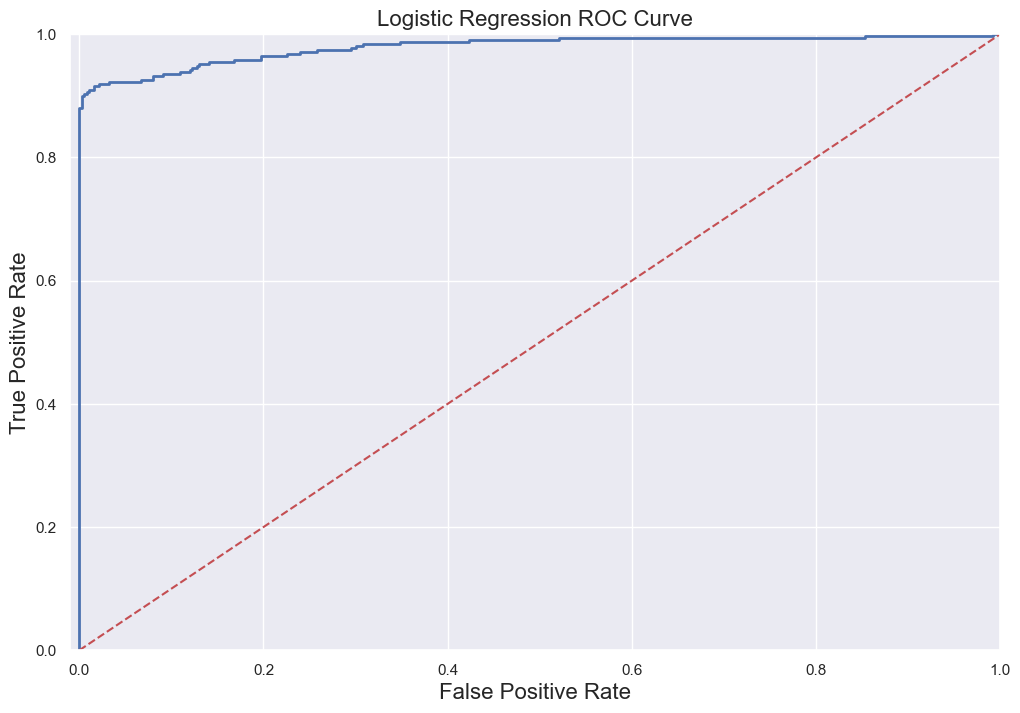

In [68]:
# Curva con mejores resultados:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

### Evaluación del modelo original
- A continuación vamos a calcular y mostrar las métricas de rendimiento (precisión, recall, F1 y exactitud) usando los datos de entrenamiento, lo que podría mostrar un sobreajuste si los valores son muy altos.
- Evaluación comparativa de estas métricas con los resultados esperados si el modelo estuviera entrenado con datos balanceados (submuestreados).

In [70]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [71]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)  # Predicción del modelo usando los datos de entrenamiento

# Caso de Sobreajuste (Overfitting)
print('---' * 45)
print('Sobreajuste: \n')
print('Puntuación de Recall: {:.2f}'.format(recall_score(y_train, y_pred)))  # Muestra la puntuación de Recall
print('Puntuación de Precisión: {:.2f}'.format(precision_score(y_train, y_pred)))  # Muestra la puntuación de Precisión
print('Puntuación F1: {:.2f}'.format(f1_score(y_train, y_pred)))  # Muestra la puntuación F1
print('Puntuación de Exactitud: {:.2f}'.format(accuracy_score(y_train, y_pred)))  # Muestra la puntuación de Exactitud
print('---' * 45)

# Cómo debería verse
print('---' * 45)
print('Cómo debería ser:\n')  # Aquí se muestra cómo deberían ser las métricas en un caso ideal
print("Puntuación de Exactitud: {:.2f}".format(np.mean(undersample_accuracy)))  # Muestra la puntuación de Exactitud para datos submuestreados
print("Puntuación de Precisión: {:.2f}".format(np.mean(undersample_precision)))  # Muestra la puntuación de Precisión para datos submuestreados
print("Puntuación de Recall: {:.2f}".format(np.mean(undersample_recall)))  # Muestra la puntuación de Recall para datos submuestreados
print("Puntuación F1: {:.2f}".format(np.mean(undersample_f1)))  # Muestra la puntuación F1 para datos submuestreados
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Sobreajuste: 

Puntuación de Recall: 0.90
Puntuación de Precisión: 0.80
Puntuación F1: 0.85
Puntuación de Exactitud: 0.85
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
Cómo debería ser:

Puntuación de Exactitud: 0.80
Puntuación de Precisión: 0.00
Puntuación de Recall: 0.16
Puntuación F1: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


### Análisis:
- **Posible sobreajuste:** El modelo parece estar sobreajustado a los datos de entrenamiento, ya que tiene un rendimiento mucho mejor en ellos que en los datos balanceados o submuestreados. Considerando que disminuimos la cantidad de datos para tener igualdad de casos de fraudes y no fraudes en el entrenamiento era una posibilidad mayor de sobreajuste en el uso real donde los datos están realmente desbalanceados
- **Problemas con los datos balanceados:** La precisión y la puntuación F1 cercanas a 0 en el conjunto de datos balanceados indican que el modelo tiene dificultades para predecir correctamente las clases positivas en ese conjunto. Esto sugiere que el modelo podría estar sesgado hacia la clase negativa, lo que es común cuando las clases están desbalanceadas.

Considerando el tema de desbalanceo, vamos a evaluar el desempeño del modelo de regresión logística mediante **average_precision_score**, usando las puntuaciones de decisión obtenidas por el modelo. Esto es útil para obtener una medida más completa del rendimiento del clasificador, especialmente cuando las clases están desbalanceadas.

In [74]:
# Calcular las puntuaciones de decisión del modelo de regresión logística para el conjunto de prueba
undersample_y_score = log_reg.decision_function(original_Xtest)

In [75]:
from sklearn.metrics import average_precision_score

# Calcular la precisión promedio usando las etiquetas reales y las puntuaciones de decisión
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Puntuación promedio de precisión-recall: {0:0.2f}'.format(undersample_average_precision))

Puntuación promedio de precisión-recall: 0.04


- Este resultado indica que el modelo tiene un rendimiento relativamente bajo en cuanto a la precisión promedio en el conjunto de prueba.
- Esta métrica combina tanto la precisión como el recall del modelo, y un puntaje de tan bajo sugiere que el modelo no está identificando correctamente las clases positivas, especialmente cuando las clases están desbalanceadas.

- Ahora vamos a generar y visualizar una curva de precisión-recall (Precisión frente a Recall) usando el resultado de un modelo de clasificación, y lo hace para un caso de undersampling.
- La curva ayuda a visualizar cómo cambian la precisión y el recall del modelo a medida que varía el umbral de decisión.
- Además, vamos a incluir la puntuación promedio de precisión-recall del código anterior en el título del gráfico.

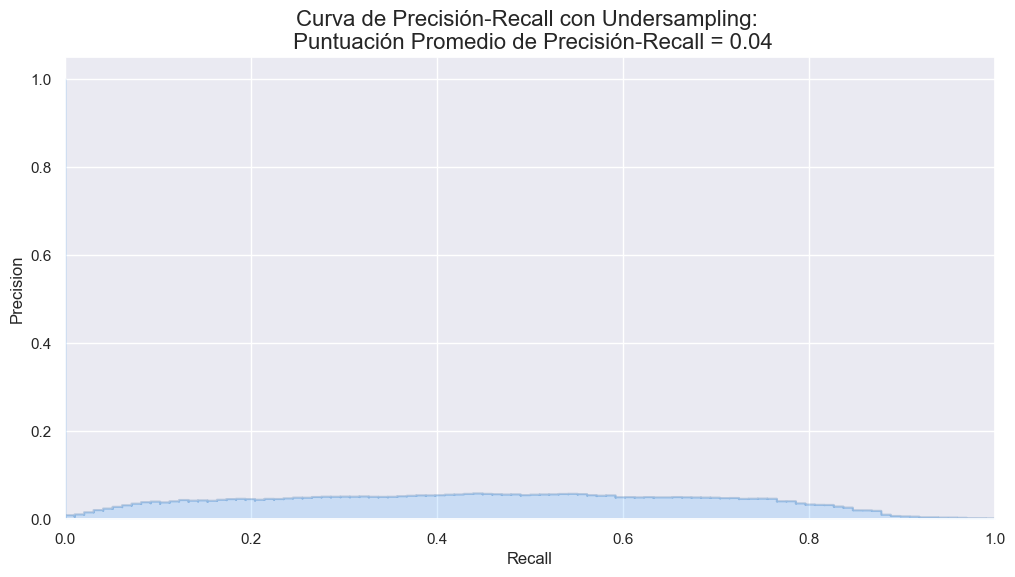

In [78]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Crear una figura de 12x6 pulgadas para la visualización
fig = plt.figure(figsize=(12,6))

# Calcular las métricas de precisión y recall usando las puntuaciones de decisión del modelo y las etiquetas reales
precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

# Dibujar la curva de precisión-recall (curva de escalón)
plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')

# Rellenar el área debajo de la curva para resaltar la gráfica
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

# Etiquetas de los ejes
plt.xlabel('Recall')  # Eje X: Recall
plt.ylabel('Precision')  # Eje Y: Precision

# Establecer los límites de los ejes
plt.ylim([0.0, 1.05])  # Límite superior del eje Y para que sea ligeramente mayor a 1
plt.xlim([0.0, 1.0])  # Límite del eje X de 0 a 1

# Título de la gráfica (traducido)
plt.title('Curva de Precisión-Recall con Undersampling: \n Puntuación Promedio de Precisión-Recall = {0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# Mostrar la gráfica
plt.show()

- Considerando que el modelo de clasificación con mejores resultados parese estar tan sobreajustado con debido al desbalance de la data
- Ahora vamos realizar una validación cruzada con la técnica SMOTE para balancear las clases, y luego ajustar el modelo de regresión logística con la búsqueda aleatoria de los mejores hiperparámetros.
- Finalmente calcularemos y mostraremos las métricas promedio (precisión, recall, F1, exactitud, AUC-ROC) del modelo.

In [80]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Longitud de X (train): {} | Longitud de y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Longitud de X (test): {} | Longitud de y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# Listas para almacenar las métricas y luego calcular el promedio
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Inicialización del clasificador con parámetros óptimos
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

# Inicialización de la búsqueda aleatoria de hiperparámetros para regresión logística
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Técnica SMOTE implementada con validación cruzada
# Definición de los parámetros para la búsqueda de mejores hiperparámetros
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Realizando la validación cruzada con SMOTE
for train, test in sss.split(original_Xtrain, original_ytrain):
    # Crear el pipeline: primero SMOTE (para balancear) y luego el modelo de regresión logística
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)  # SMOTE ocurre durante la validación cruzada, no antes..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])  # Entrenar el modelo
    best_est = rand_log_reg.best_estimator_  # Obtener el mejor clasificador encontrado
    prediction = best_est.predict(original_Xtrain[test])  # Realizar la predicción sobre el conjunto de prueba
    
    # Almacenar las métricas de desempeño para cada partición
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

# Imprimir las métricas promedio obtenidas de la validación cruzada
print('---' * 45)
print('')
print("Puntuación de Exactitud: {}".format(np.mean(accuracy_lst)))
print("Puntuación de Precisión: {}".format(np.mean(precision_lst)))
print("Puntuación de Recall: {}".format(np.mean(recall_lst)))
print("Puntuación F1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Longitud de X (train): 227846 | Longitud de y (train): 227846
Longitud de X (test): 56961 | Longitud de y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

Puntuación de Exactitud: 0.9419088095228224
Puntuación de Precisión: 0.06258252972412603
Puntuación de Recall: 0.9162934112301201
Puntuación F1: 0.11533756815664375
---------------------------------------------------------------------------------------------------------------------------------------


El modelo tiene una alta exactitud, pero la baja precisión y la baja puntuación F1 sugieren que, aunque puede identificar correctamente una gran parte de las instancias positivas, está cometiendo muchos falsos positivos, lo que afecta su capacidad de hacer predicciones correctas. El alto recall indica que el modelo está siendo efectivo al identificar la clase positiva, pero esto se logra a costa de precisión, lo cual es típico en modelos que sufren de un desbalance de clases. En resumen, el modelo podría estar muy sesgado hacia la clase positiva, lo que lleva a una alta tasa de falsos positivos.

Ahora vamos a realizar un reporte detallado sobre cómo el modelo ha clasificado las instancias de "No Fraud" y "Fraud" en el conjunto de prueba.

In [83]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.85      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



### Conclusión:
- El modelo tiene un excelente rendimiento en la predicción de "No Fraud" (precisión, recall y F1 muy altos), pero tiene dificultades para predecir "Fraud".
- El problema se debe al desbalance de clases, ya que "Fraud" es mucho menos frecuente en los datos, lo que hace que el modelo sea muy sesgado hacia la clase mayoritaria "No Fraud".
- Aunque la exactitud total es alta, el modelo tiene un pobre desempeño en la clase minoritaria "Fraud", lo que podría ser un problema en aplicaciones del mundo real, donde es crucial detectar fraudes.

- Ahora vamos a evaluar el rendimiento del modelo en términos de la precisión y el recall, utilizando **average_precision_score** basado en la curva de precisión-recall, que es más adecuado en escenarios con clases desbalanceadas como mencionamos anteriormente.

In [85]:
y_score = best_est.decision_function(original_Xtest)

In [86]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.75


Este fue un resultado relativamente mejor que el anterior pero sigue sin ser el ideal

Text(0.5, 1.0, 'Curva de Precisión-Recall con OverSampling: \n Puntuación de Precisión-Recall Promedio =0.75')

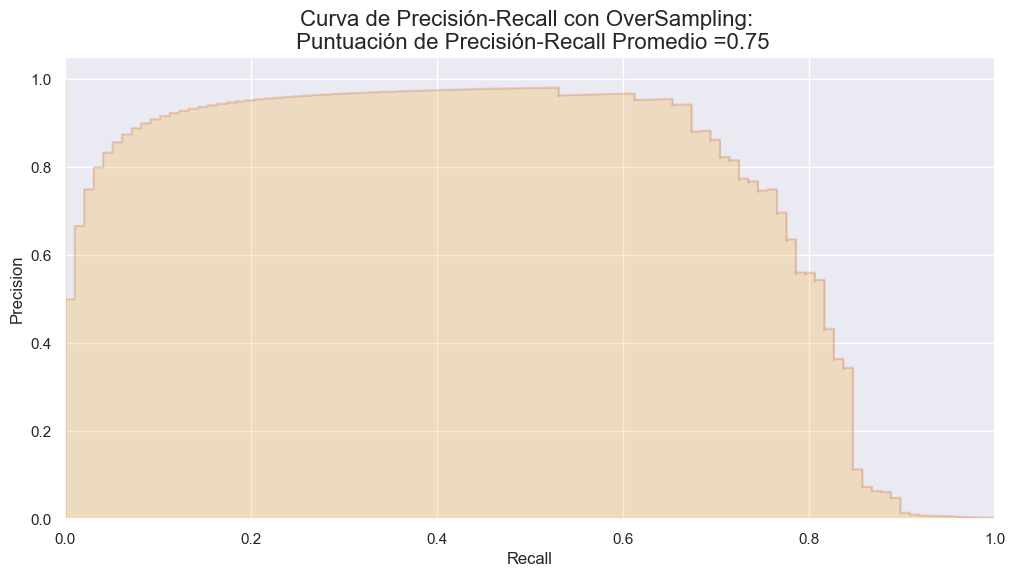

In [88]:
# Crear una figura para el gráfico
fig = plt.figure(figsize=(12,6))

# Calcular la curva de precisión-recall usando los valores verdaderos y las predicciones
precision, recall, _ = precision_recall_curve(original_ytest, y_score)

# Dibujar la curva de precisión-recall utilizando pasos
plt.step(recall, precision, color='r', alpha=0.2, where='post')
# Rellenar el área bajo la curva con un color semi-transparente
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

# Etiquetas para los ejes
plt.xlabel('Recall')  # Etiqueta del eje X (Recall)
plt.ylabel('Precision')  # Etiqueta del eje Y (Precision)

# Ajustar los límites de los ejes para que estén entre 0 y 1
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Título del gráfico con la puntuación de precisión promedio
plt.title('Curva de Precisión-Recall con OverSampling: \n Puntuación de Precisión-Recall Promedio ={0:0.2f}'.format(
    average_precision), fontsize=16)


In [89]:
# Técnica SMOTE (OverSampling) después de la división y validación cruzada
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Aplicar SMOTE sobre el conjunto de entrenamiento
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

# Regresión Logística
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("El ajuste de los datos sobremuestreados tomó :{} seg".format(t1 - t0))

El ajuste de los datos sobremuestreados tomó :1.8989031314849854 seg


### Datos de prueba con Logistic Regression:

#### Matriz de confusión:

- Positivo/Negativo: Tipo de clase (etiqueta) ["No", "Sí"] Verdadero/Falso: Clasificación correcta o incorrecta según el modelo.
- Verdaderos negativos (Cuadro superior izquierdo): Número de clasificaciones correctas de la clase "No" (No se detectó fraude).
- Falsos negativos (Cuadro superior derecho): Número de clasificaciones incorrectas de la clase "No" (No se detectó fraude).
- Falsos positivos (Cuadro inferior izquierdo): Número de clasificaciones incorrectas de la clase "Sí" (No se detectó fraude).
- Verdaderos positivos (Cuadro inferior derecho): Número de clasificaciones correctas de la clase "Sí" (No se detectó fraude).

Ahora vamos a calcular y mostrar las matrices de confusión para los modelos de clasificación que hemos trabajado, pero ajustando cada uno con diferentes técnicas de muestreo (SMOTE y UnderSampling).

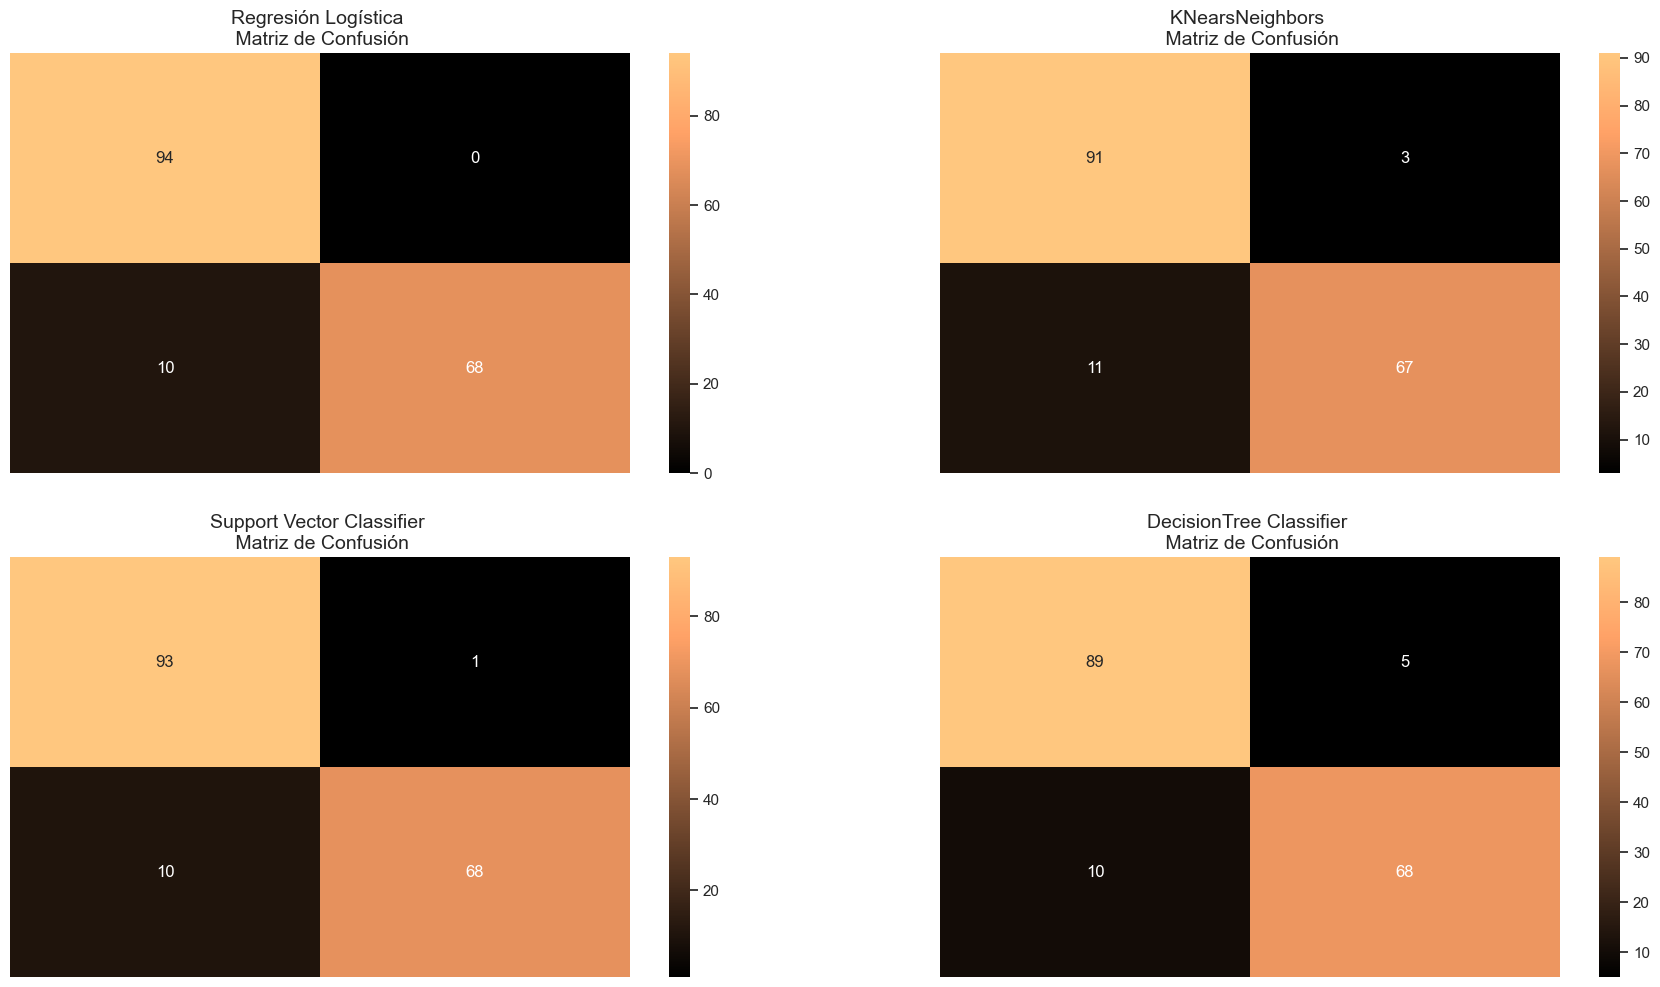

In [92]:
from sklearn.metrics import confusion_matrix

# Regresión Logística ajustada utilizando la técnica SMOTE
y_pred_log_reg = log_reg_sm.predict(X_test)

# Otros modelos ajustados con UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

# Calculando las matrices de confusión
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

# Creando una figura con 4 subgráficos
fig, ax = plt.subplots(2, 2, figsize=(22, 12))

# Mapa de calor para la matriz de confusión de Regresión Logística
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Regresión Logística \n Matriz de Confusión", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Mapa de calor para la matriz de confusión de K-Nearest Neighbors
sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Matriz de Confusión", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Mapa de calor para la matriz de confusión de Support Vector Classifier
sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Support Vector Classifier \n Matriz de Confusión", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Mapa de calor para la matriz de confusión de DecisionTree Classifier
sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Matriz de Confusión", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Mostrar la figura
plt.show()

Ahora vamos a evaluar el rendimiento de los cuatro modelos utilizando la métrica **classification_report** de sklearn.metrics.

In [94]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        94
           1       1.00      0.87      0.93        78

    accuracy                           0.94       172
   macro avg       0.95      0.94      0.94       172
weighted avg       0.95      0.94      0.94       172

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        94
           1       0.96      0.86      0.91        78

    accuracy                           0.92       172
   macro avg       0.92      0.91      0.92       172
weighted avg       0.92      0.92      0.92       172

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        94
           1       0.99      0.87      0.93        78

    accuracy                           0.94       172
   macro avg       0.94      0.93      0.93       172
weighted

### Análisis
- La Regresión Logística tiene el mejor desempeño en general con una precisión y recall balanceados.
- K-Vecinos y SVC también tienen buen desempeño, aunque el recall en la clase 1 es más bajo lo cual no es nuestro ideal ya que buscamos detectar fraudes.

In [96]:
# Puntaje final en el conjunto de prueba para la regresión logística
from sklearn.metrics import accuracy_score

# Regresión Logística con Submuestreo (Under-Sampling)
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Regresión Logística con la técnica SMOTE
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

# Crear un DataFrame con los puntajes obtenidos
d = {'Técnica': ['Submuestreo Aleatorio', 'Sobre-muestreo (SMOTE)'], 
     'Puntaje': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Mover la columna
score = final_df['Puntaje']
final_df.drop('Puntaje', axis=1, inplace=True)
final_df.insert(1, 'Puntaje', score)


final_df

,Técnica,Puntaje
0,Submuestreo Aleatorio,0.941860
1,Sobre-muestreo (SMOTE),0.988308


Los resultados muestran que la técnica SMOTE ha dado un mejor desempeño en términos de precisión en comparación con Random UnderSampling.
- SMOTE mejora el modelo, aumentando la precisión en el conjunto de prueba.
- UnderSampling es menos efectivo, ya que reduce la cantidad de datos y puede perder información valiosa.

Sin embargo hemos comprobado anteriormente que este puntaje de precisión alto no significa verdaderamente que sea un mejor modelo, el deesbalance de clases del dataset nos obliga a revisar métricas como recall, precisión y F1-score para asegurarnos de que el modelo generaliza bien y no simplemente memoriza las clases mayoritarias.

### Redes Neuronales: Prueba de Datos de Submuestreo Aleatorio vs. Sobremuestreo (SMOTE):

En esta sección, implementaremos una red neuronal simple (con una capa oculta) para determinar cuál de los dos modelos de regresión logística implementados en SMOTE (submuestreo o sobremuestreo) ofrece mayor precisión para detectar transacciones fraudulentas y no fraudulentas.

#### Nuestro Objetivo Principal:

Nuestro objetivo principal es explorar el comportamiento de nuestra red neuronal simple en los marcos de datos de submuestreo y sobremuestreo aleatorios, y comprobar si pueden predecir con precisión tanto casos de fraude como de no fraude. Esto ya que la idea del algoritmo en la práctica pueda ser capaz de distinguir si un cliente titular de una tarjeta ha hecho una compra, ésta no se boquée por fraude, así que es importante una correcta categorización en ambos lados

Estructura de la red neuronal: 
- este modelo simple consta de una capa de entrada más un nodo de sesgo una capa oculta con 32 nodos y un nodo de salida compuesto por dos posibles resultados: 0 o 1 (sin fraude o fraude).
- Otras características: La tasa de aprendizaje será de 0,001, el optimizador que utilizaremos es AdamOptimizer, la función de activación que se utiliza en este escenario es "Relu" y para los resultados finales utilizaremos entropía cruzada categórica dispersa, que da la probabilidad de que un caso de instancia no sea fraude o sea fraude (la predicción elegirá la probabilidad más alta entre las dos).

In [99]:
import keras
from keras import backend as K  # Backend de Keras para operaciones de bajo nivel
from keras.models import Sequential  # Modelo secuencial de Keras
from keras.layers import Activation, Dense  # Capas de activación y densas
from keras.optimizers import Adam  # Optimizador Adam
from keras.metrics import categorical_crossentropy  # Métrica de pérdida para clasificación multiclase

# Definimos la cantidad de entradas (features) en el modelo
n_inputs = X_train.shape[1]

# Creamos un modelo de red neuronal secuencial para clasificación binaria
undersample_model = Sequential([
    # Primera capa oculta con el mismo número de neuronas que las entradas, activación ReLU
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    
    # Segunda capa oculta con 32 neuronas y activación ReLU
    Dense(32, activation='relu'),
    
    # Capa de salida con 2 neuronas (correspondientes a las 2 clases) y activación Softmax
    # Softmax convierte las salidas en probabilidades (la suma de ambas será 1)
    Dense(2, activation='softmax')
])

2025-03-20 15:53:15.668760: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-20 15:53:15.668976: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-20 15:53:15.668994: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-20 15:53:15.669276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-20 15:53:15.669295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [100]:
# Verificamos la estructura del modelo antes de compilarlo y entrenarlo, así aseguramos de que el número de parámetros es el esperado.
undersample_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,988 (7.77 KB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Compilamos el modelo
undersample_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [102]:
# Entrenamos el modelo
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20


2025-03-20 15:53:16.216690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 - 1s - 61ms/step - accuracy: 0.7203 - loss: 0.5188 - val_accuracy: 0.7810 - val_loss: 0.5832
Epoch 2/20
22/22 - 0s - 9ms/step - accuracy: 0.8135 - loss: 0.3708 - val_accuracy: 0.8540 - val_loss: 0.4676
Epoch 3/20
22/22 - 0s - 10ms/step - accuracy: 0.8958 - loss: 0.2955 - val_accuracy: 0.8613 - val_loss: 0.4003
Epoch 4/20
22/22 - 0s - 9ms/step - accuracy: 0.9342 - loss: 0.2456 - val_accuracy: 0.8905 - val_loss: 0.3623
Epoch 5/20
22/22 - 0s - 9ms/step - accuracy: 0.9506 - loss: 0.2089 - val_accuracy: 0.9124 - val_loss: 0.3330
Epoch 6/20
22/22 - 0s - 10ms/step - accuracy: 0.9580 - loss: 0.1851 - val_accuracy: 0.9197 - val_loss: 0.3150
Epoch 7/20
22/22 - 0s - 9ms/step - accuracy: 0.9580 - loss: 0.1651 - val_accuracy: 0.9270 - val_loss: 0.3029
Epoch 8/20
22/22 - 0s - 10ms/step - accuracy: 0.9598 - loss: 0.1542 - val_accuracy: 0.9270 - val_loss: 0.2944
Epoch 9/20
22/22 - 0s - 9ms/step - accuracy: 0.9525 - loss: 0.1428 - val_accuracy: 0.9270 - val_loss: 0.2902
Epoch 10/20
22/22 - 0s - 1

In [103]:
# Generación de predicciones en el conjunto de prueba
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [104]:
# Obtener la clase predicha
undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest, batch_size=200, verbose=0), axis=1)

In [105]:
import itertools

# Crear una matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    # Si se selecciona normalizar, se divide cada valor de la matriz por la suma de su fila correspondiente
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión, sin normalización')

    # Imprimir la matriz de confusión
    print(cm)

    # Graficar la matriz de confusión usando el mapa de colores especificado
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)  # Título del gráfico
    plt.colorbar()  # Barra de colores

    # Crear las marcas de los ejes x y y
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)  # Etiquetas para el eje x
    plt.yticks(tick_marks, classes)  # Etiquetas para el eje y

    # Configurar el formato de los valores dentro de la matriz (decimales o enteros)
    fmt = '.2f' if normalize else 'd'
    
    # Umbral para determinar el color del texto dentro de las celdas
    thresh = cm.max() / 2.
    
    # Añadir los valores de la matriz dentro de las celdas
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Escribir el valor de la matriz en cada celda
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Color del texto dependiendo del valor

    # Ajustar el diseño para que todo se vea bien
    plt.tight_layout()
    
    # Etiquetas de los ejes
    plt.ylabel('Etiqueta verdadera')  
    plt.xlabel('Etiqueta predicha')


Matriz de confusión, sin normalización
[[54109  2754]
 [    9    89]]
Matriz de confusión, sin normalización
[[56863     0]
 [    0    98]]


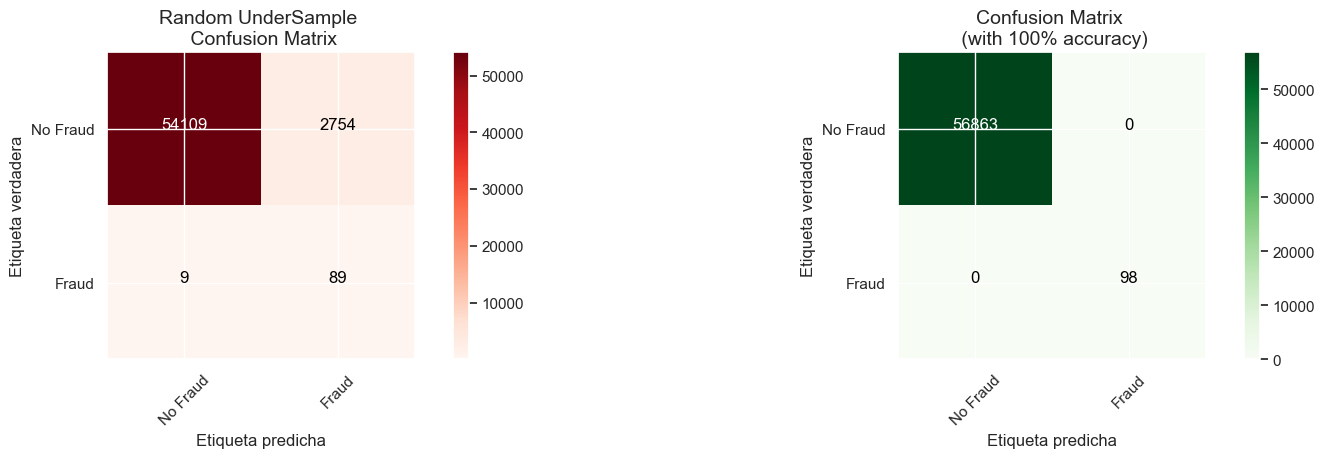

In [106]:
# Crear la matriz de confusión para las predicciones del modelo con under-sampling
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)

# Crear la matriz de confusión para las etiquetas verdaderas (sin predicciones, para mostrar la precisión perfecta)
actual_cm = confusion_matrix(original_ytest, original_ytest)

# Definir las etiquetas para las clases
labels = ['No Fraud', 'Fraud']

# Crear una figura para mostrar las matrices de confusión
fig = plt.figure(figsize=(16,8))

# Subgráfico 1: Mostrar la matriz de confusión para el modelo con under-sampling
fig.add_subplot(221)  # 2 filas, 2 columnas, primer gráfico
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

# Subgráfico 2: Mostrar la matriz de confusión para las etiquetas verdaderas (precisión perfecta)
fig.add_subplot(222)  # 2 filas, 2 columnas, segundo gráfico
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Keras || OverSampling (SMOTE)

In [108]:
# Hacemos un nuevo modelo de red neuronal con un sobre-muestreo (SMOTE)
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [109]:
# Compilamos el código
oversample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [110]:
# Entrenamos el modelo
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 10s - 9ms/step - accuracy: 0.9468 - loss: 0.1430 - val_accuracy: 0.8970 - val_loss: 0.2249
Epoch 2/20
1214/1214 - 10s - 8ms/step - accuracy: 0.9531 - loss: 0.1374 - val_accuracy: 0.9028 - val_loss: 0.3325
Epoch 3/20
1214/1214 - 10s - 8ms/step - accuracy: 0.9462 - loss: 0.1820 - val_accuracy: 0.9001 - val_loss: 0.4067
Epoch 4/20
1214/1214 - 9s - 8ms/step - accuracy: 0.9425 - loss: 0.2301 - val_accuracy: 0.9283 - val_loss: 0.2781
Epoch 5/20
1214/1214 - 9s - 8ms/step - accuracy: 0.9393 - loss: 0.2867 - val_accuracy: 0.9124 - val_loss: 0.3250
Epoch 6/20
1214/1214 - 10s - 8ms/step - accuracy: 0.9396 - loss: 0.2978 - val_accuracy: 0.8602 - val_loss: 0.8659
Epoch 7/20
1214/1214 - 10s - 9ms/step - accuracy: 0.9357 - loss: 0.3963 - val_accuracy: 0.9037 - val_loss: 0.4807
Epoch 8/20
1214/1214 - 10s - 8ms/step - accuracy: 0.9336 - loss: 0.4702 - val_accuracy: 0.8930 - val_loss: 1.3760
Epoch 9/20
1214/1214 - 10s - 8ms/step - accuracy: 0.9301 - loss: 0.6461 - val_accuracy: 0.

In [111]:
# Generación de predicciones en el conjunto de prueba
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [112]:
# Obtener la clase predicha 
predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(predictions, axis=1)  # Obtiene la clase con mayor probabilidad

Matriz de confusión, sin normalización
[[51279  5584]
 [   42    56]]
Matriz de confusión, sin normalización
[[56863     0]
 [    0    98]]


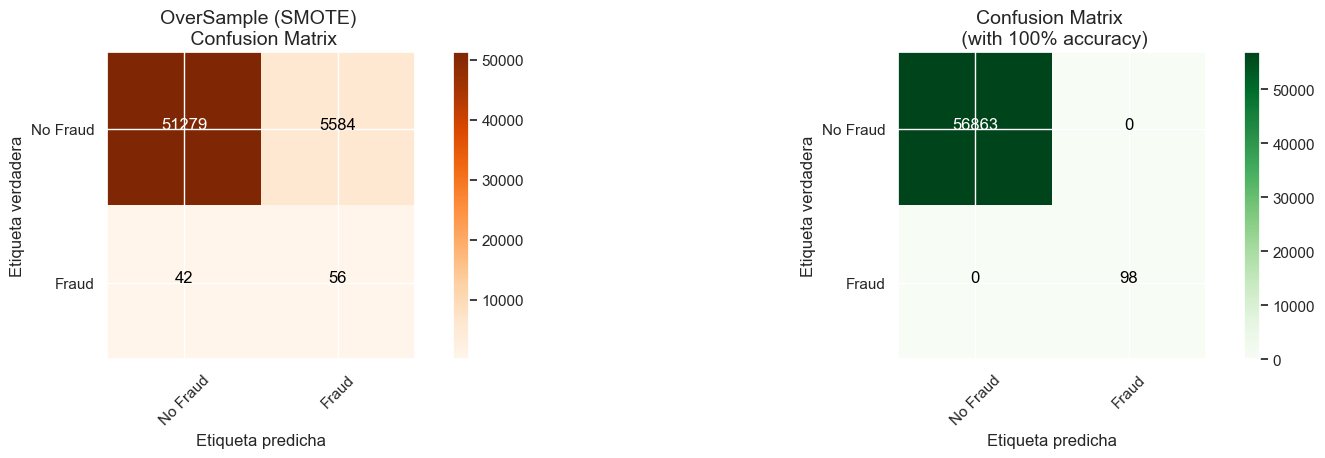

In [127]:
# Calcular la matriz de confusión para el modelo con SMOTE
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)

# Calcular la matriz de confusión "ideal" (100% de precisión)
actual_cm = confusion_matrix(original_ytest, original_ytest)

# Definir las etiquetas para las clases
labels = ['No Fraud', 'Fraud']

# Crear la figura para los subgráficos
fig = plt.figure(figsize=(16,8))

# Agregar el primer subgráfico para la matriz de confusión del modelo con SMOTE
fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

# Agregar el segundo subgráfico para la matriz de confusión ideal (100% de precisión)
fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Conclusión:

Implementar SMOTE en nuestro conjunto de datos desequilibrado nos ayudó con el desequilibrio de nuestras etiquetas (más transacciones sin fraude que con fraude). Sin embargo, cabe mencionar que, en ocasiones, la red neuronal del conjunto de datos sobremuestreado predice menos transacciones fraudulentas correctas que nuestro modelo que utiliza el conjunto de datos submuestreado. Cabe recordar que la eliminación de valores atípicos se implementó solo en el conjunto de datos submuestreado aleatorio, no en el sobremuestreado. Además, en nuestros datos submuestreados, nuestro modelo no puede detectar correctamente las transacciones sin fraude en un gran número de casos y, en cambio, las clasifica erróneamente como casos de fraude. Imaginemos que a las personas que realizaban compras habituales se les bloquea la tarjeta porque nuestro modelo clasificó esa transacción como fraudulenta; esto representaría una gran desventaja para la institución financiera. Aumentaría el número de quejas y la insatisfacción de los clientes. El siguiente paso de este análisis será eliminar los valores atípicos en nuestro conjunto de datos sobremuestreado y comprobar si mejora la precisión en el conjunto de prueba.

Nota: Por último, las predicciones y la precisión pueden estar sujetas a cambios desde que implementé la reorganización de datos en ambos tipos de marcos de datos. Lo principal es comprobar si nuestros modelos pueden clasificar correctamente las transacciones fraudulentas y las no fraudulentas. Les daré más información, ¡estén atentos!